In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
import torch
import torch.nn as nn
from matplotlib.colors import Normalize

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
file_path = '/kaggle/input/burgers-solution-1000-v0-01/burger_solution_1000_0.01_upwind_scheme.npy' # change it accordingly

In [3]:
with open(file_path, 'rb') as f:
    usol =  np.load(f)

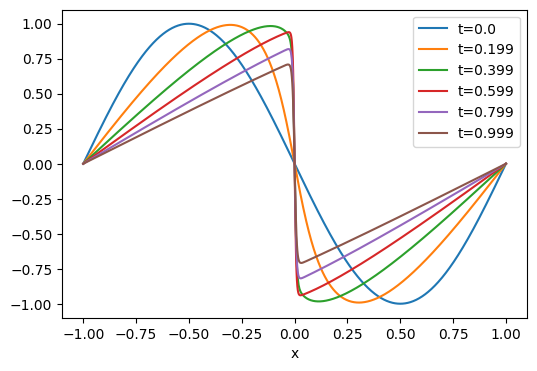

In [4]:
# Visualize some of the data, for some values of t
fig, ax = plt.subplots(1,figsize=(6,4))
for j in [0,199,399,599,799,999]:
    ax.plot(np.linspace(-1, 1, 1000), usol[j,:], label=f't={j/usol.shape[0]}')
ax.set_xlabel('x')
ax.legend()
fig.show()

# the first dimension is t (usol[t,:] is all x at time t)
# second dimension is x 

In [5]:
class ScalingLayer(nn.Module):
    def __init__(self, scale_init_value=1, bias_init_value=0):
        super().__init__()
        self.scale = nn.Parameter(torch.FloatTensor([scale_init_value]))
        self.bias = nn.Parameter(torch.FloatTensor([bias_init_value]))

    def forward(self, input):
        return input * self.scale + self.bias
    
    
class U(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
class F(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### Get Collocation points

In [6]:
def generate_latin_hyper_c_sampling(Nd=10000):
    sampler = qmc.LatinHypercube(d=2)
    sample_pos = sampler.random(n=Nd//2) # [0,1)^2
    sample_neg = sampler.random(n=Nd//2) # [0,1)^2
    sample_neg[:,1] = -sample_neg[:,1]

    return np.vstack([sample_pos, sample_neg])

In [7]:
collocation_p = generate_latin_hyper_c_sampling(10**4)

In [8]:
collocation_p

array([[ 0.30280756,  0.92382498],
       [ 0.34116128,  0.85772509],
       [ 0.68460867,  0.87084714],
       ...,
       [ 0.222592  , -0.37710055],
       [ 0.04241356, -0.07366263],
       [ 0.24413914, -0.98217907]])

In [9]:
# first column is in range [0,1] (represents t)
assert collocation_p[:,0].min() > 0
assert collocation_p[:,0].max() < 1

# second column is in range [-1,1] (represents x)
assert collocation_p[:,1].min() > -1
assert collocation_p[:,1].max() < 1

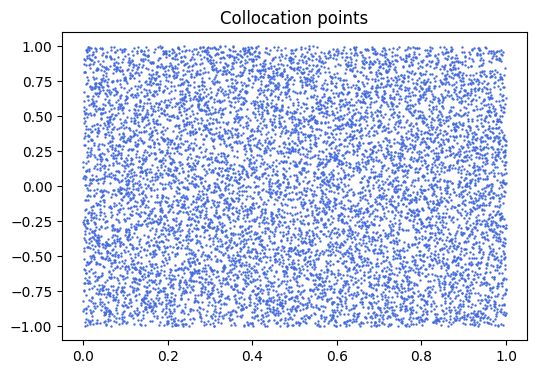

In [10]:
fig, ax = plt.subplots(1,figsize=(6,4))
ax.scatter(collocation_p[:,0], collocation_p[:,1], s=0.5, color='royalblue')
ax.set_title('Collocation points')
fig.show()

### Get training data

In [11]:
def get_train_data(n, t, usol, noise=5e-3):
    t_index = int(t*usol.shape[1])
    
    x_indices = np.arange(0, usol.shape[1], usol.shape[1]//n)
    u_vals = usol[t_index, x_indices]
    u_vals = u_vals.reshape(-1,1)
    
    x_vals = ((x_indices * (2/1000)) -1)
    x_vals = x_vals.reshape(-1,1)
    t_vals = np.array([t]*x_vals.shape[0])
    t_vals = t_vals.reshape(-1,1)
    
    # INPUT: [[0,x1],[0,x2], [0,x3]...[0,x_n]], TARGET = u_vals
    
    u_vals += (np.random.normal(loc=0.0, scale=1.0, size=u_vals.shape[0]) * noise).reshape(-1,1)
    
    return np.concatenate([t_vals, x_vals], axis=1), u_vals

In [12]:
train_data_t05, target_t05 = get_train_data(100, 0.5, usol, noise=5e-3)
train_data_t0, target_t0 = get_train_data(100, 0, usol, noise=5e-3)

train_data = np.concatenate([train_data_t05, train_data_t0], axis=0)
train_targets = np.concatenate([target_t05, target_t0], axis=0)

# print(train_data.shape)
# print(train_targets.shape)

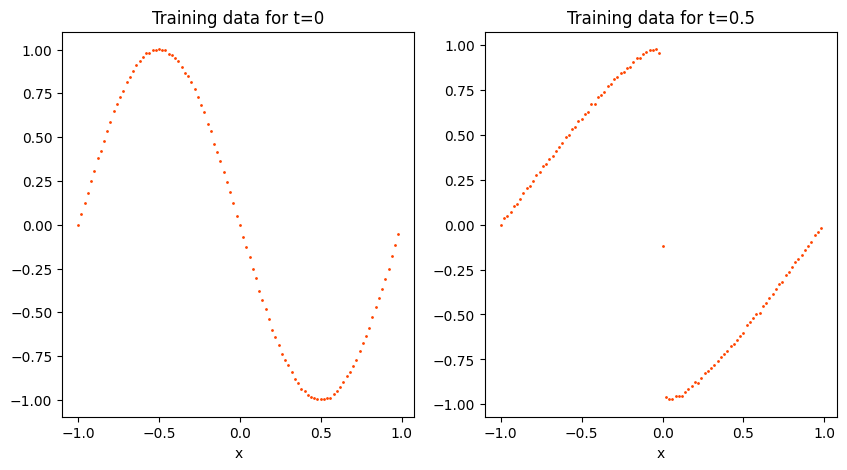

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(train_data_t0[:,1], target_t0[:,0], s=1, color='orangered')
ax[0].set_title('Training data for t=0')
ax[0].set_xlabel('x')
ax[1].scatter(train_data_t05[:,1], target_t05[:,0], s=1, color='orangered')
ax[1].set_title('Training data for t=0.5')
ax[1].set_xlabel('x')
fig.show()

In [14]:
def get_boundary_points(n=100):
    sampler = qmc.LatinHypercube(d=1)
    sample_pos = sampler.random(4*n)
    
    u_initial = lambda x: -np.sin(np.pi * x)
    
    top_b = sample_pos[:100]
    top_b = np.concatenate([top_b, np.ones_like(top_b)],axis=1)
    top_b_target = np.zeros((top_b.shape[0],1))

    bot_b = sample_pos[100:200]
    bot_b = np.concatenate([bot_b, np.ones_like(bot_b)*-1],axis=1)
    bot_b_target = np.zeros((bot_b.shape[0],1))
    
    x_b = sample_pos[200:300]
    x_b = np.concatenate([np.zeros_like(x_b), x_b],axis=1)
    x_b_target = u_initial(x_b[:,1]).reshape(-1,1)

    
    negx_b = -sample_pos[300:]
    negx_b = np.concatenate([np.zeros_like(negx_b), negx_b],axis=1)
    negx_b_target = u_initial(negx_b[:,1]).reshape(-1,1)
    
    return np.concatenate([top_b, bot_b, x_b, negx_b],axis=0), np.concatenate([top_b_target, 
                                                                               bot_b_target, 
                                                                               x_b_target, 
                                                                              negx_b_target], axis=0)

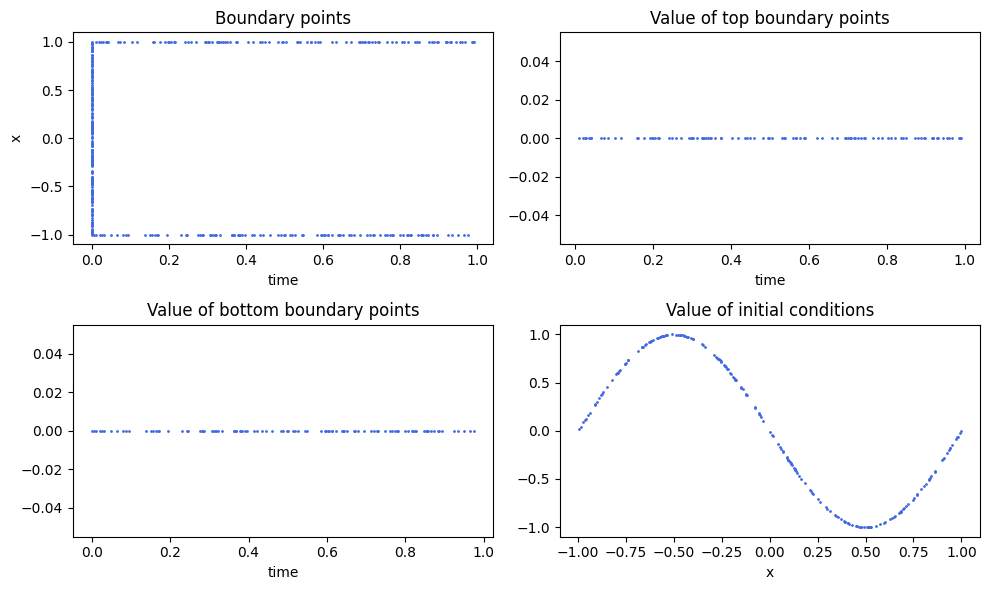

In [15]:
fig, ax = plt.subplots(2,2, figsize=(10,6))

boundary_points, boundary_targets = get_boundary_points(100)

ax[0,0].scatter(boundary_points[:,0], boundary_points[:,1], s=1.0, color='royalblue')
ax[0,0].set_title('Boundary points')
ax[0,0].set_xlabel('time')
ax[0,0].set_ylabel('x')

ax[0,1].scatter(boundary_points[:100,0], boundary_targets[:100], s=1.0, color='royalblue')
ax[0,1].set_title('Value of top boundary points')
ax[0,1].set_xlabel('time')

ax[1,0].scatter(boundary_points[100:200,0], boundary_targets[100:200], s=1.0, color='royalblue')
ax[1,0].set_title('Value of bottom boundary points')
ax[1,0].set_xlabel('time')

ax[1,1].scatter(boundary_points[200:,1], boundary_targets[200:], s=1.0, color='royalblue')
ax[1,1].set_title('Value of initial conditions')
ax[1,1].set_xlabel('x')

fig.tight_layout()

### Training

In [114]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# put data on device
collocation_p = torch.Tensor(collocation_p).to(device).requires_grad_(True)
boundary_points = torch.Tensor(boundary_points).to(device)
boundary_targets = torch.Tensor(boundary_targets).to(device)
train_data = torch.Tensor(train_data).to(device)
train_targets = torch.Tensor(train_targets).to(device)

In [115]:
u = U(2,1, [20]*8)
u = u.to(device)

f = F(3,1, [20]*8)
f = f.to(device)

In [116]:
def get_loss(boundary_points, boundary_targets, collocation_p, train_data, train_targets, lambdas):
    lambda1, lambda2, lambda3 = lambdas[0], lambdas[1], lambdas[2]
    
    # boundary loss -------
    u_b = u(boundary_points)
    loss1 = nn.MSELoss()(u_b, boundary_targets)
    

    # Physics loss -------
    u_p = u(collocation_p)
    # retain graph?
    dudxt = torch.autograd.grad(u_p, collocation_p, torch.ones_like(u_p), create_graph=True)[0]
    dudt = dudxt[:,0]
    dudx = dudxt[:,1]
    
    du2dx2 = torch.autograd.grad(dudxt, collocation_p, 
                                 torch.ones_like(dudxt), create_graph=True)[0][:,1]
    
    f_input = torch.cat([u_p,dudt.reshape(-1,1),dudx.reshape(-1,1)], axis=1)
    f_p = f(f_input)
    
    v = 1 / (100 * np.pi)
    loss2 = nn.MSELoss()(-dudt.reshape(-1,1) + f_p + v * du2dx2.reshape(-1,1), torch.zeros_like(dudt.reshape(-1,1)))
    
    # Datapoint loss -------
    u_n = u(train_data)
    loss3 = nn.MSELoss()(u_n, train_targets)
    
    loss = lambda1*loss1 + lambda2*loss2  + lambda3*loss3
    return loss, loss1, loss2, loss3

In [117]:
def plot_solution(usol, u, f):
    
    # Compute u, dudx and F(u, dudx, dudt) to plot the true, estimated and learned unknown component N_k
    # The unknown component should be: -u * dudx
    x_points = (torch.linspace(-1,1,1000)).reshape(-1,1)
    t_points = (torch.ones_like(x_points)*0.75).reshape(-1,1)
    tx_points = torch.cat([t_points, x_points], axis=1).to(device).requires_grad_(True)
    
    u_plot = u(tx_points)
    
    dudxt_plot = torch.autograd.grad(u_plot, tx_points, torch.ones_like(u_plot), create_graph=True)[0]
    dudt_plot = dudxt_plot[:,0].reshape(-1,1)
    dudx_plot = dudxt_plot[:,1].reshape(-1,1)
    f_input_plot = torch.cat([u_plot, dudt_plot,dudx_plot], axis=1)
    f_plot = f(f_input_plot)
    
    # Compute dudx from the true solution u using finite difference
    # We consider the timestep t=0.75 so that the result is interpretable
    # and it is a timestep without any training data 
    true_u = usol[750,:]
    dudx_upwind = np.zeros((1000,1))
    
    dx = 2 / 1000
    for i in range(1, true_u.shape[0]-1):
            if true_u[i] >= 0:
                    dudx_upwind[i] = (true_u[i] - true_u[i-1]) / dx
            else:
                    dudx_upwind[i] = (true_u[i+1] - true_u[i]) / dx
    
    with torch.no_grad():
            # Get a meshgrid of points to display an image of the solution u in the
            # domain x=[-1,1] and t=[0,1]
            t_phys = np.linspace(0, 1, 10**2)
            x_phys = np.linspace(-1, 1, 10**2)
            x_mesh, t_mesh = np.meshgrid(x_phys, t_phys)

            coordinates = np.vstack((t_mesh.flatten(), x_mesh.flatten())).T
            coordinates = torch.Tensor(coordinates).to(device)
            
            u_p = u(coordinates).detach().cpu().numpy()
            u_mesh = u_p.reshape(x_mesh.shape)

            data_min = np.min(u_p)
            data_max = np.max(u_p)

            # Contour plot
            fig, ax = plt.subplots(2,2,figsize=(20,10))
            norm = Normalize(vmin=data_min, vmax=data_max)
            img = ax[0,0].imshow(u_mesh.T, cmap='viridis', 
                                 aspect='auto', 
                                 extent=[0, 1, 1, -1])
            fig.colorbar(img, ax=ax[0,0])

            ax[0,0].set_xlabel('t')
            ax[0,0].set_ylabel('x')
            ax[0,0].set_title('Contour plot of the Viscous Burgers Equation Approximation')
            
            # Slices
            # Visualize some of u predictions, for some values of t
            colors = ['royalblue', 'forestgreen', 'darkorange', 'firebrick']
            for i,(j,k) in enumerate(zip([0,500,750,999], [0,50,75,99])):
                ax[0,1].plot(np.linspace(-1, 1, 1000), usol[j,:], 
                             label=f't={j/usol.shape[0]}', color=colors[i])
                ax[0,1].plot(np.linspace(-1, 1, 100), 
                             u_mesh[k,:], linestyle='--', color=colors[i])
            ax[0,1].set_xlabel('x')
            ax[0,1].legend()
            fig.show()
            
            # plot the unknown term learned by F vs the true interaction
            expected = -(u_plot * dudx_plot).detach().cpu().numpy()
            ax[1,0].plot(np.linspace(-0.25, 0.25, 250), expected[375:625], label='Expected unknown')
            ax[1,0].plot(np.linspace(-0.25, 0.25, 250), f_plot.detach().cpu().numpy()[375:625], label='F', linestyle='--')
            ax[1,0].plot(np.linspace(-0.25, 0.25, 250), (-true_u.reshape(-1,1)*dudx_upwind)[375:625], label='True unknown')
            ax[1,0].legend()
            ax[1,0].set_title('Unknown term at time t=0.75')

            
            plt.show()
    

Boundary L: 0.2684420645236969, Phys L: 0.2318350076675415, Data L: 0.46763741970062256


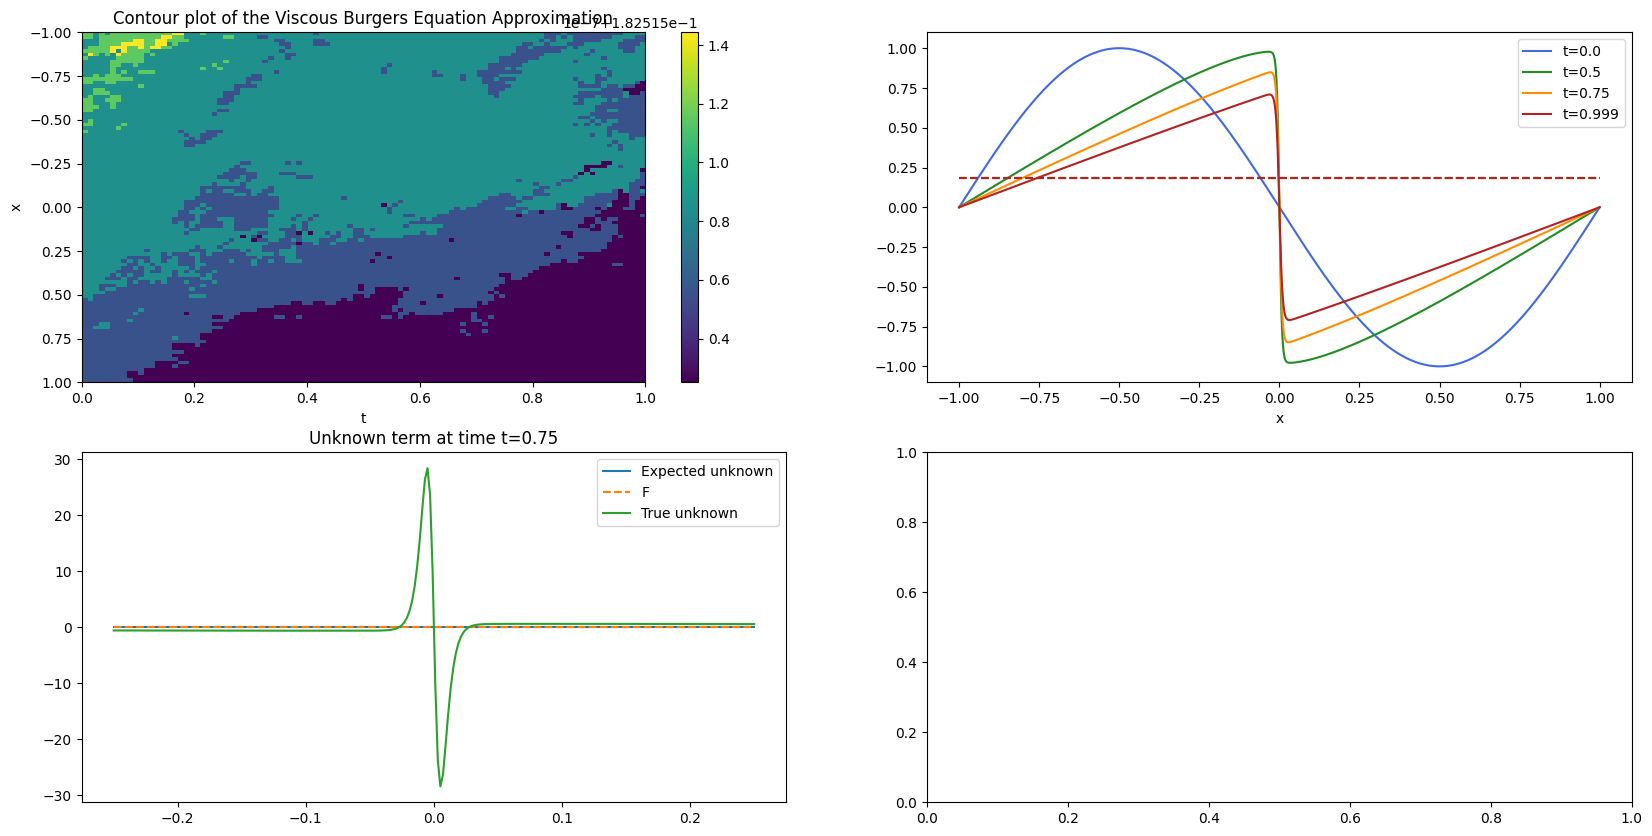

Boundary L: 0.00040951251867227256, Phys L: 0.0006139649194665253, Data L: 0.007596255745738745


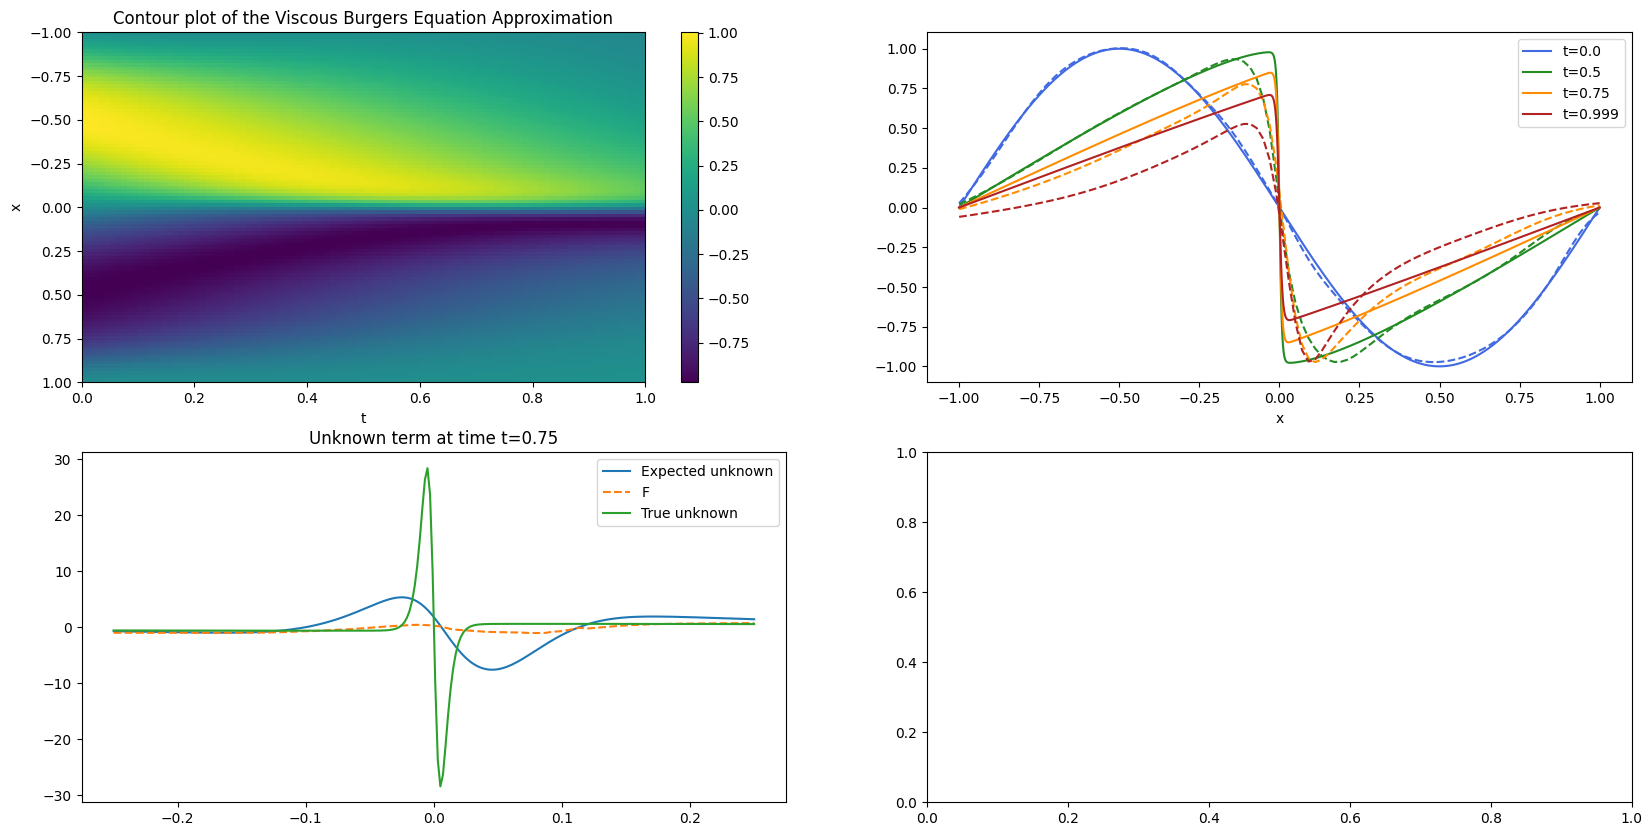

Boundary L: 8.514295041095465e-05, Phys L: 0.00024871673667803407, Data L: 0.0022178911603987217


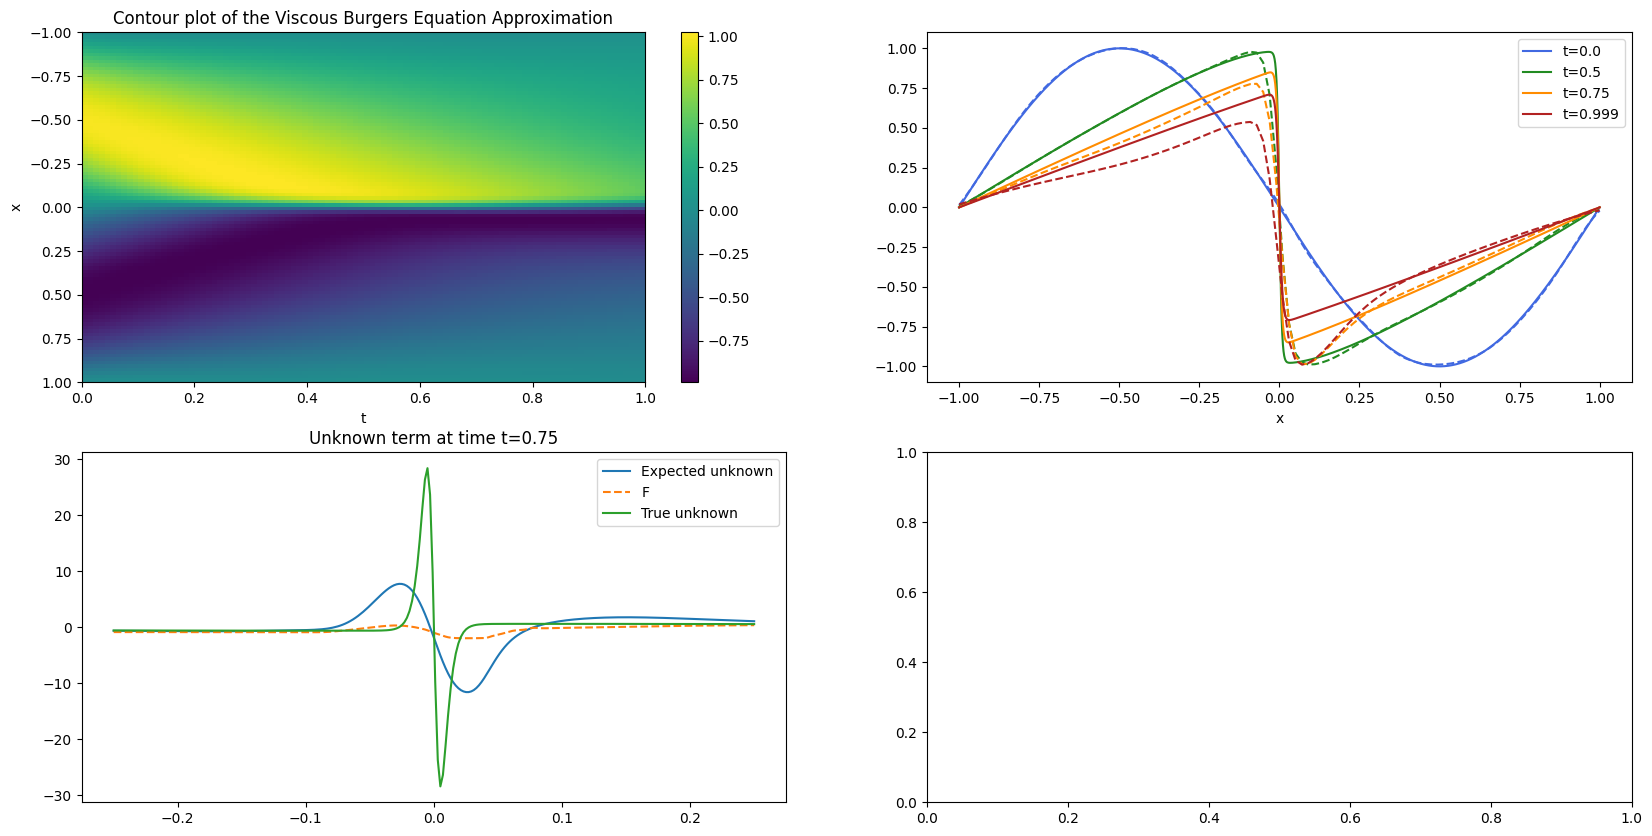

Boundary L: 0.00011490874749142677, Phys L: 0.0002603030879981816, Data L: 0.0014431753661483526


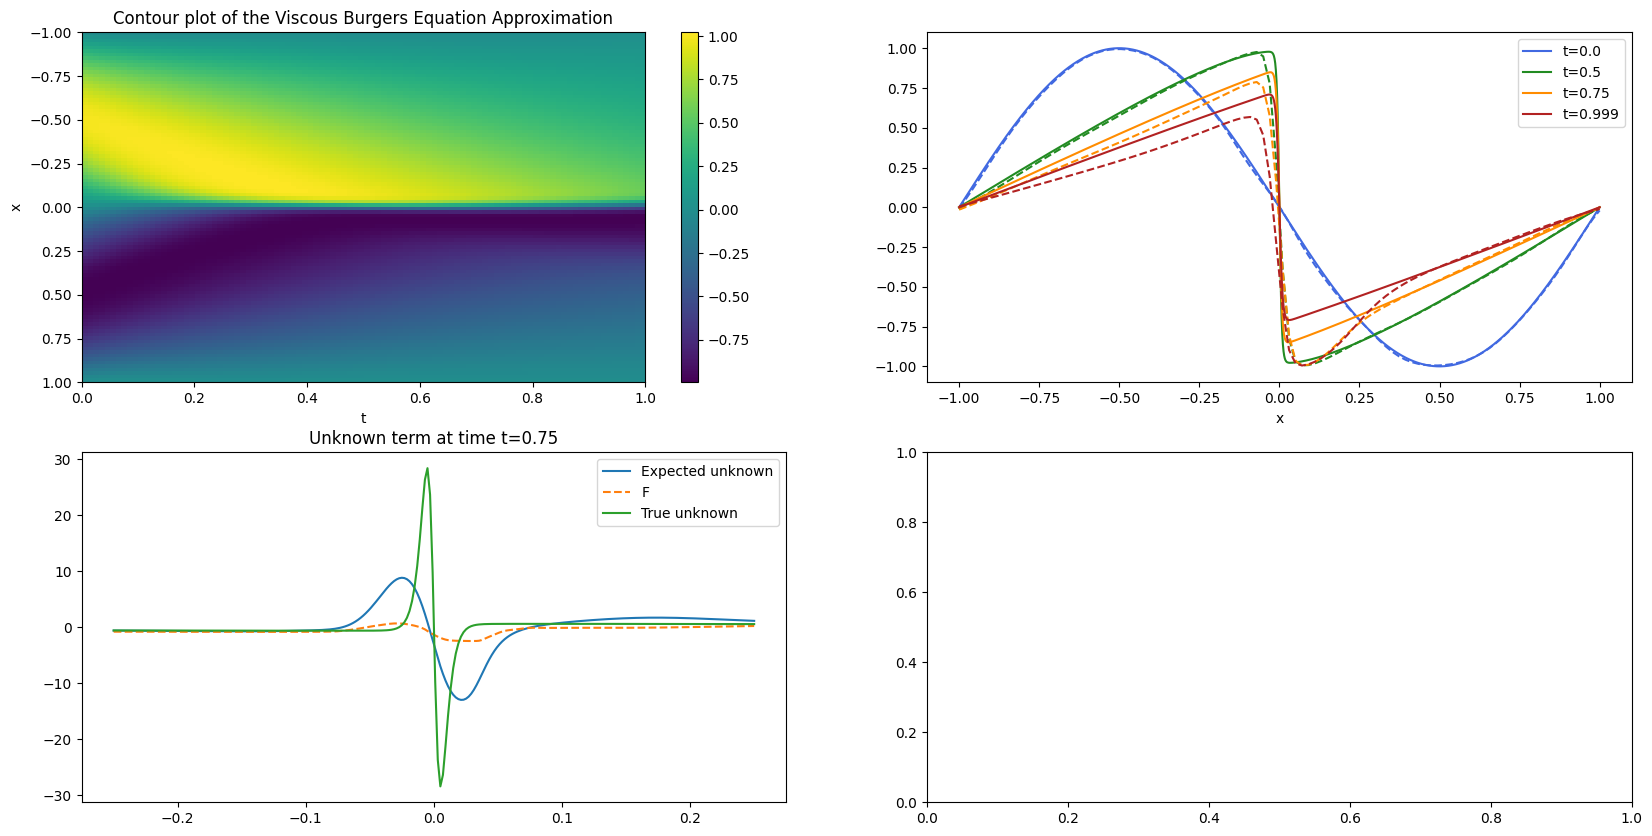

Boundary L: 3.101780384895392e-05, Phys L: 0.00011642920435406268, Data L: 0.0011279487516731024


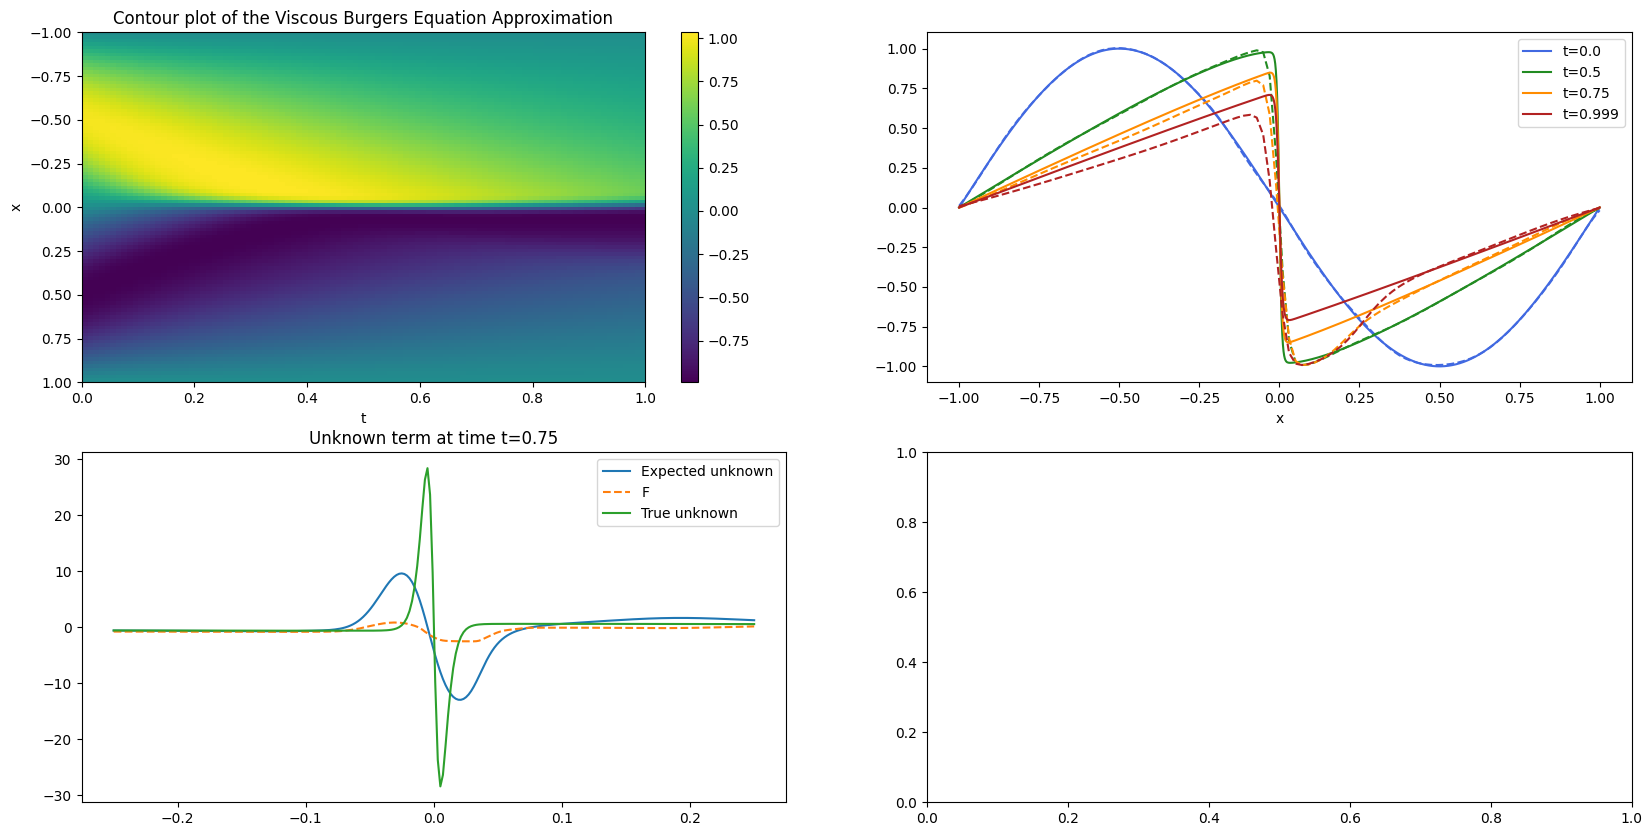

Boundary L: 2.4021863282541744e-05, Phys L: 9.536547440802678e-05, Data L: 0.0009378786780871451


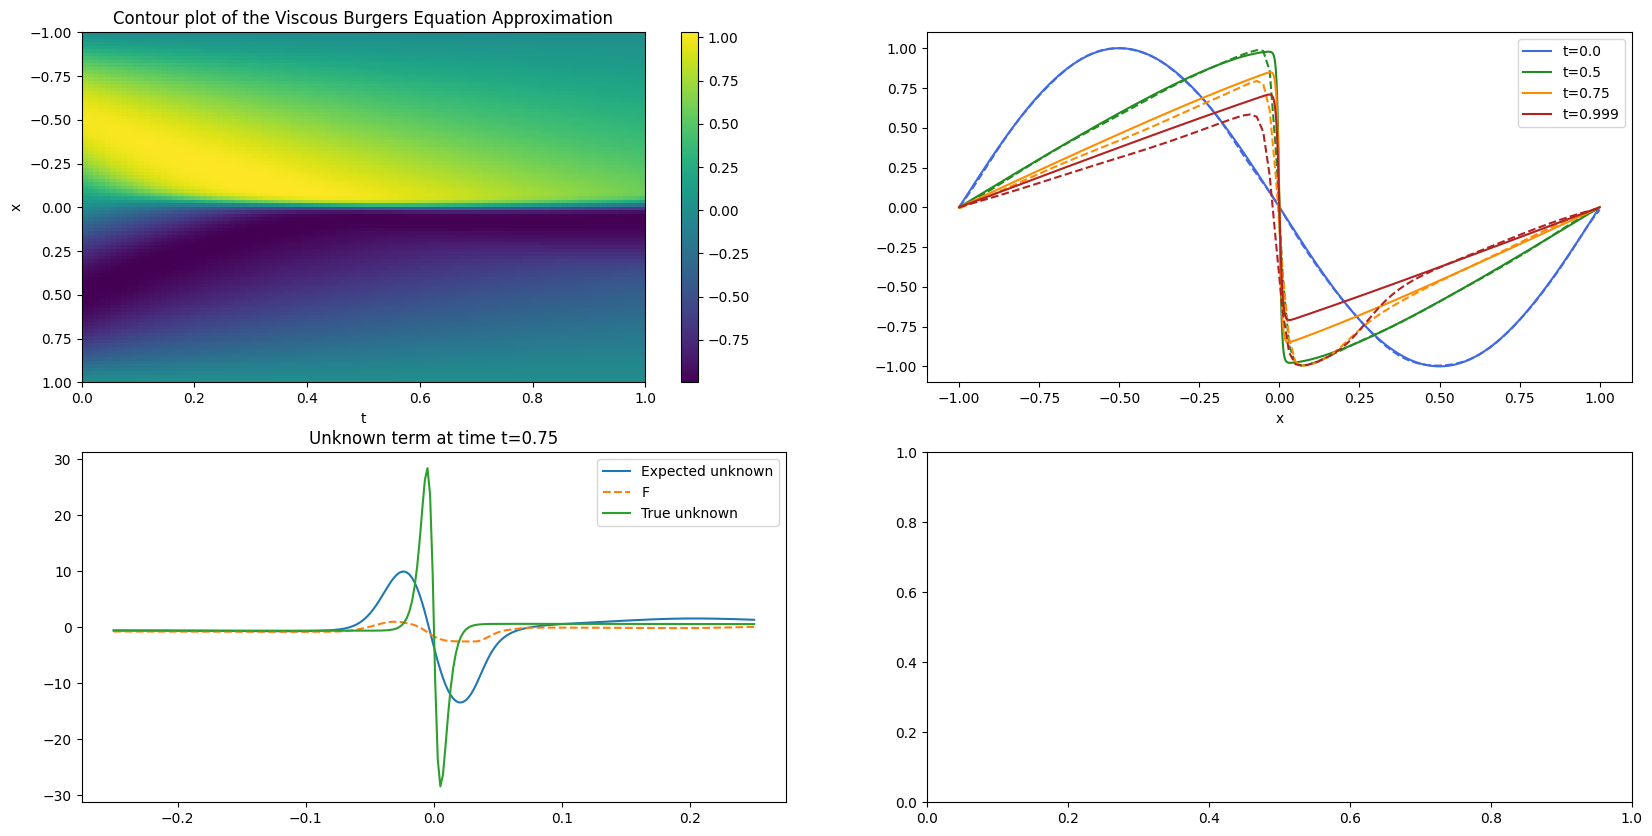

Boundary L: 0.00033966326736845076, Phys L: 0.0008938589016906917, Data L: 0.0012991145486012101


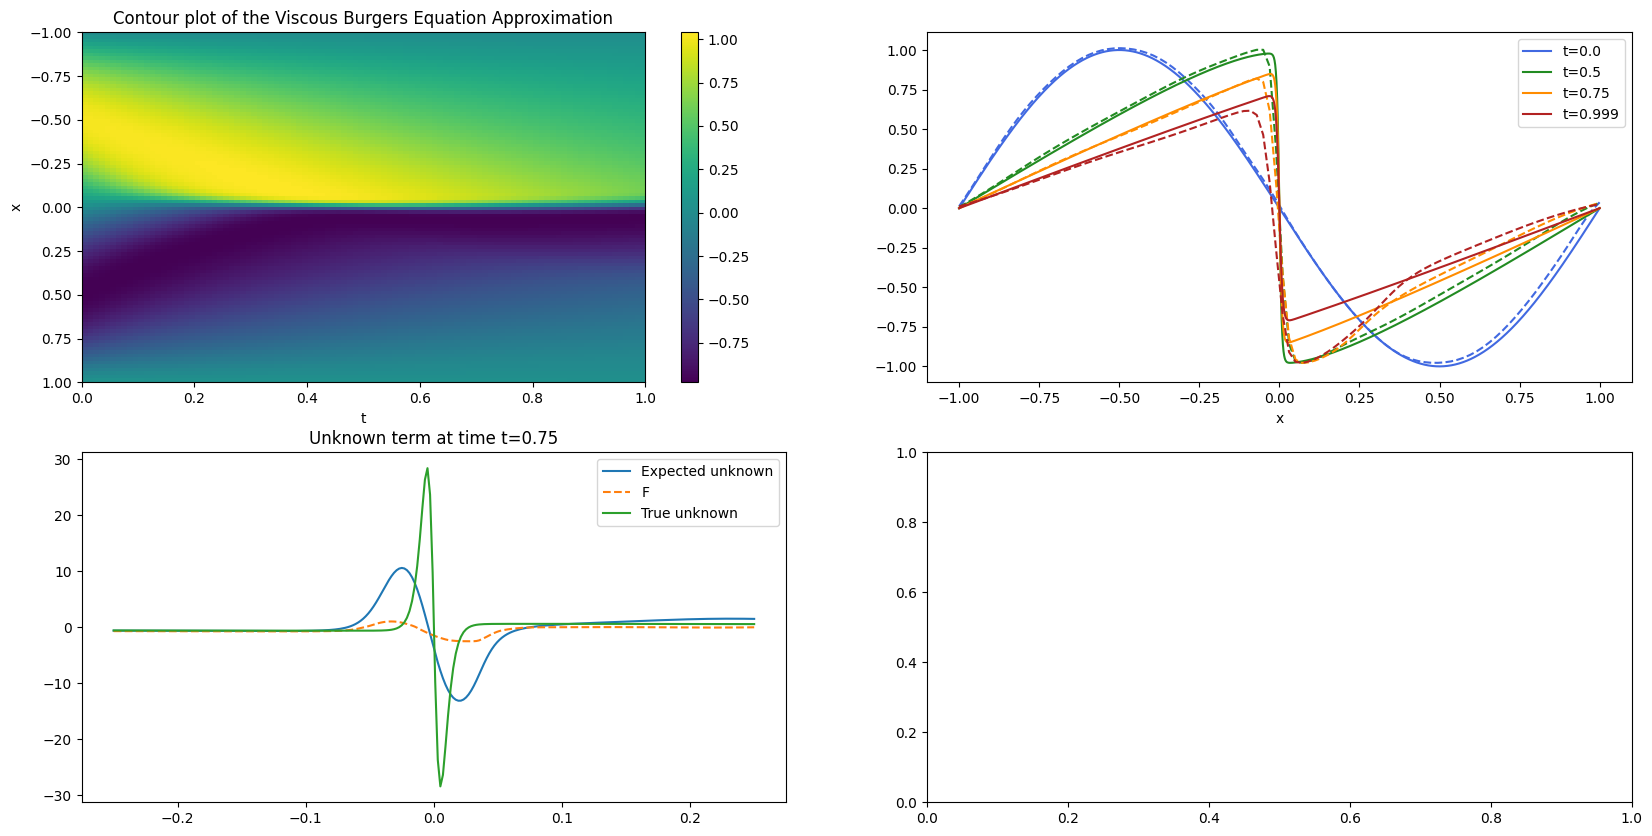

Boundary L: 0.00013827907969243824, Phys L: 0.0004993112524971366, Data L: 0.0007725199102424085


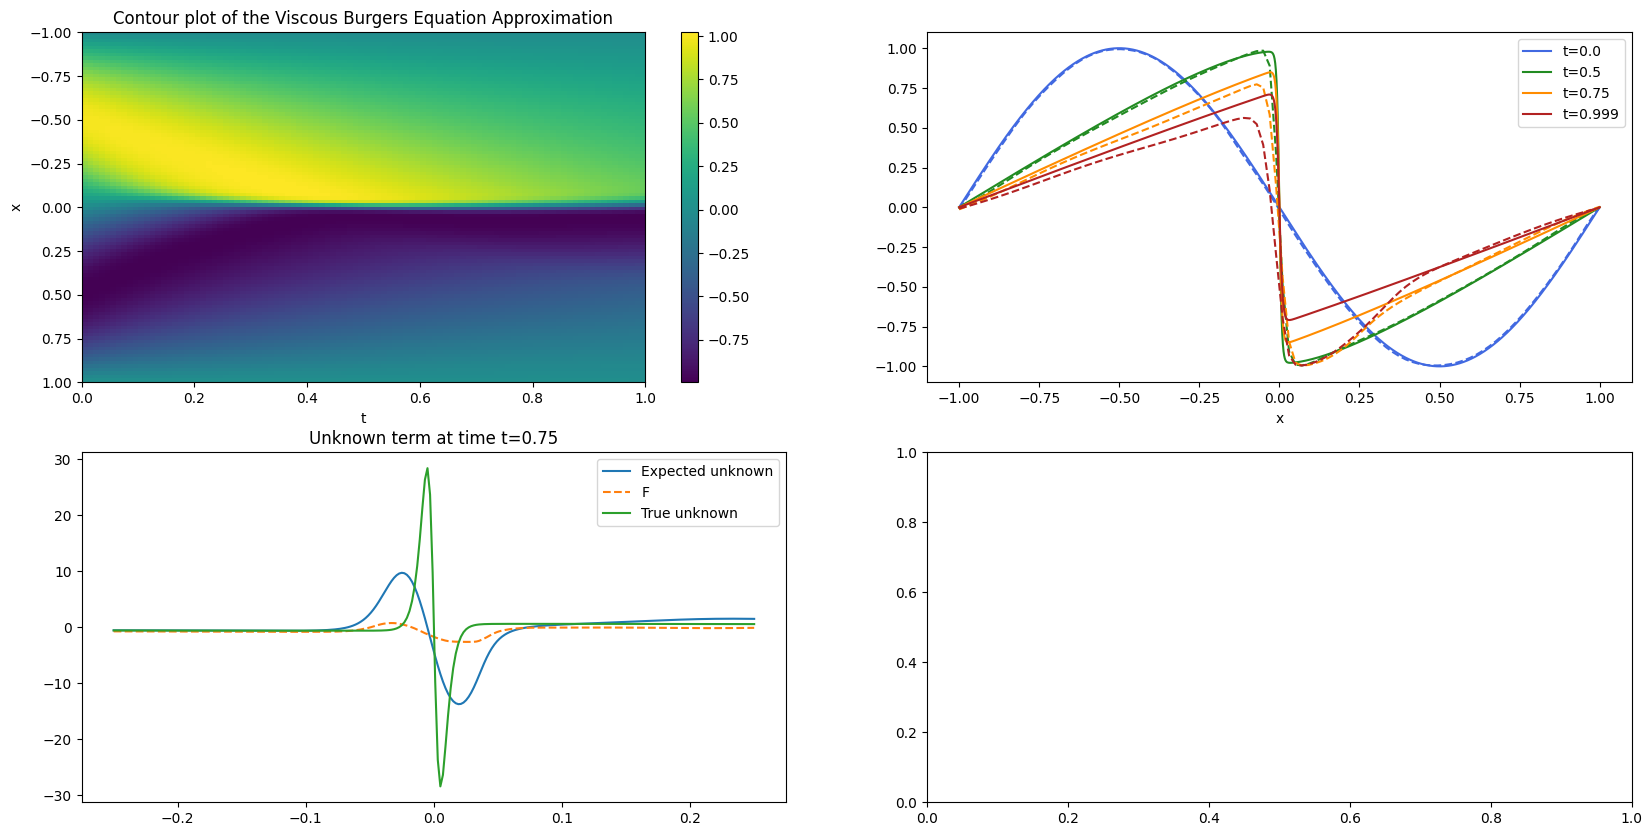

Boundary L: 4.255400926922448e-05, Phys L: 0.00017433743050787598, Data L: 0.0005649416125379503


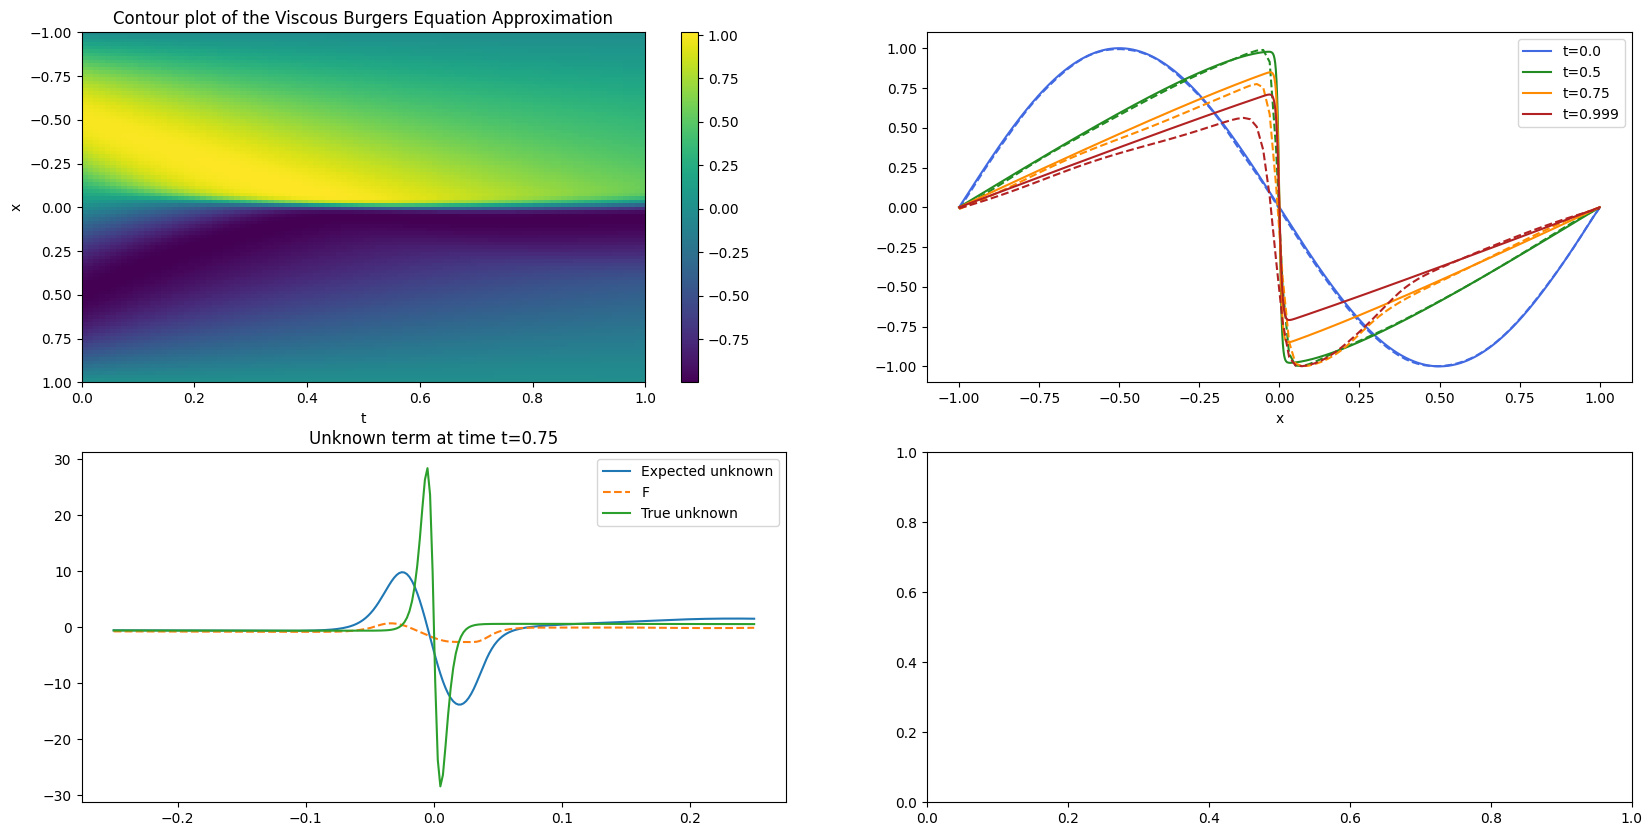

Boundary L: 1.6164167391252704e-05, Phys L: 6.024880349286832e-05, Data L: 0.0004962423699907959


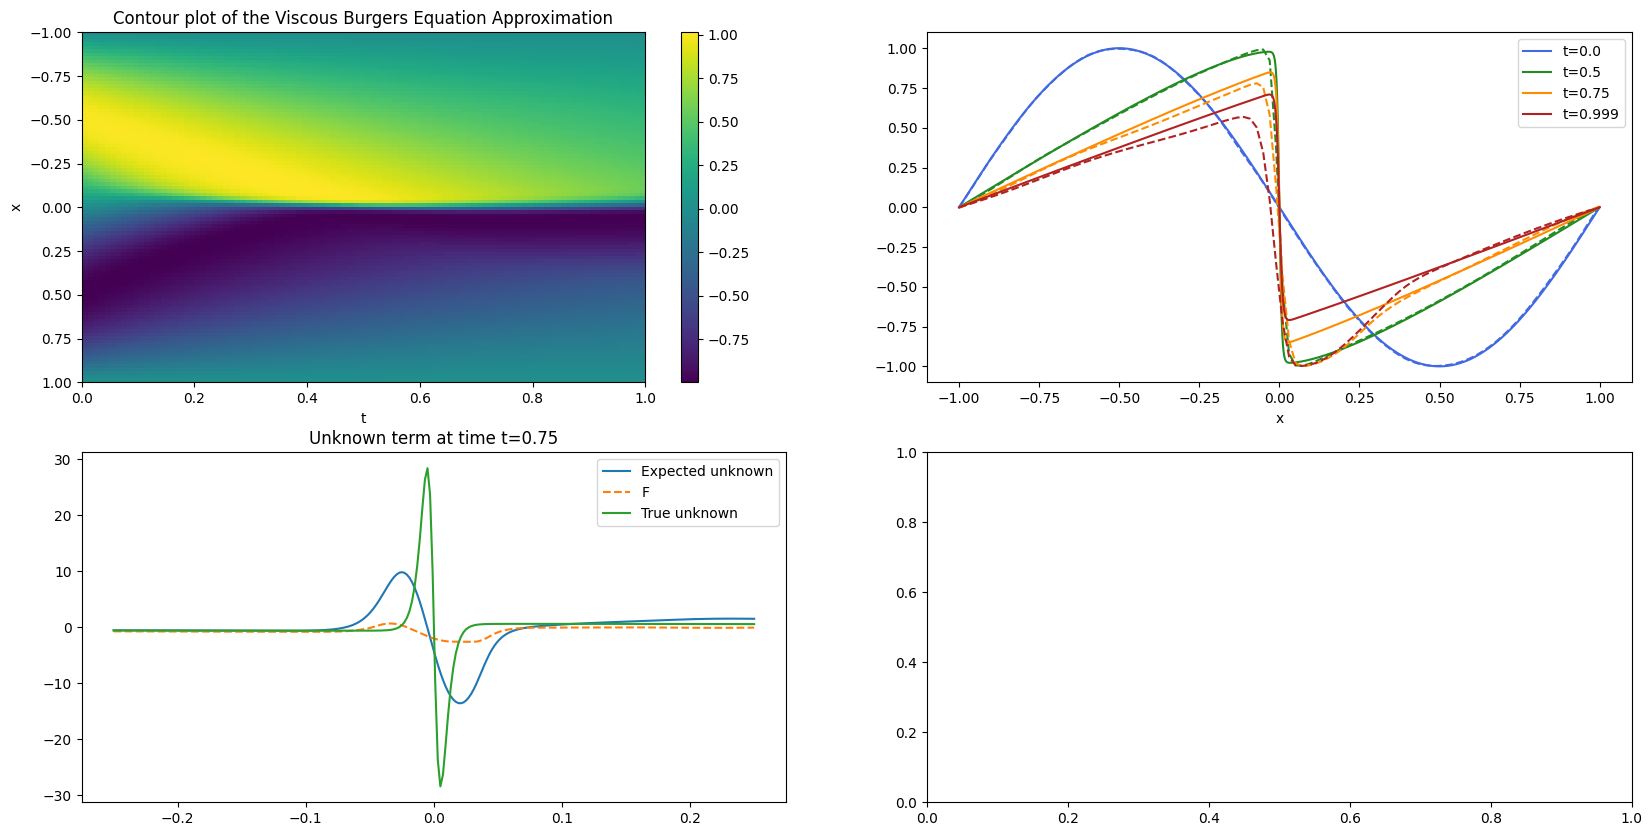

Boundary L: 1.5164862816163804e-05, Phys L: 0.00010555228072917089, Data L: 0.000471699662739411


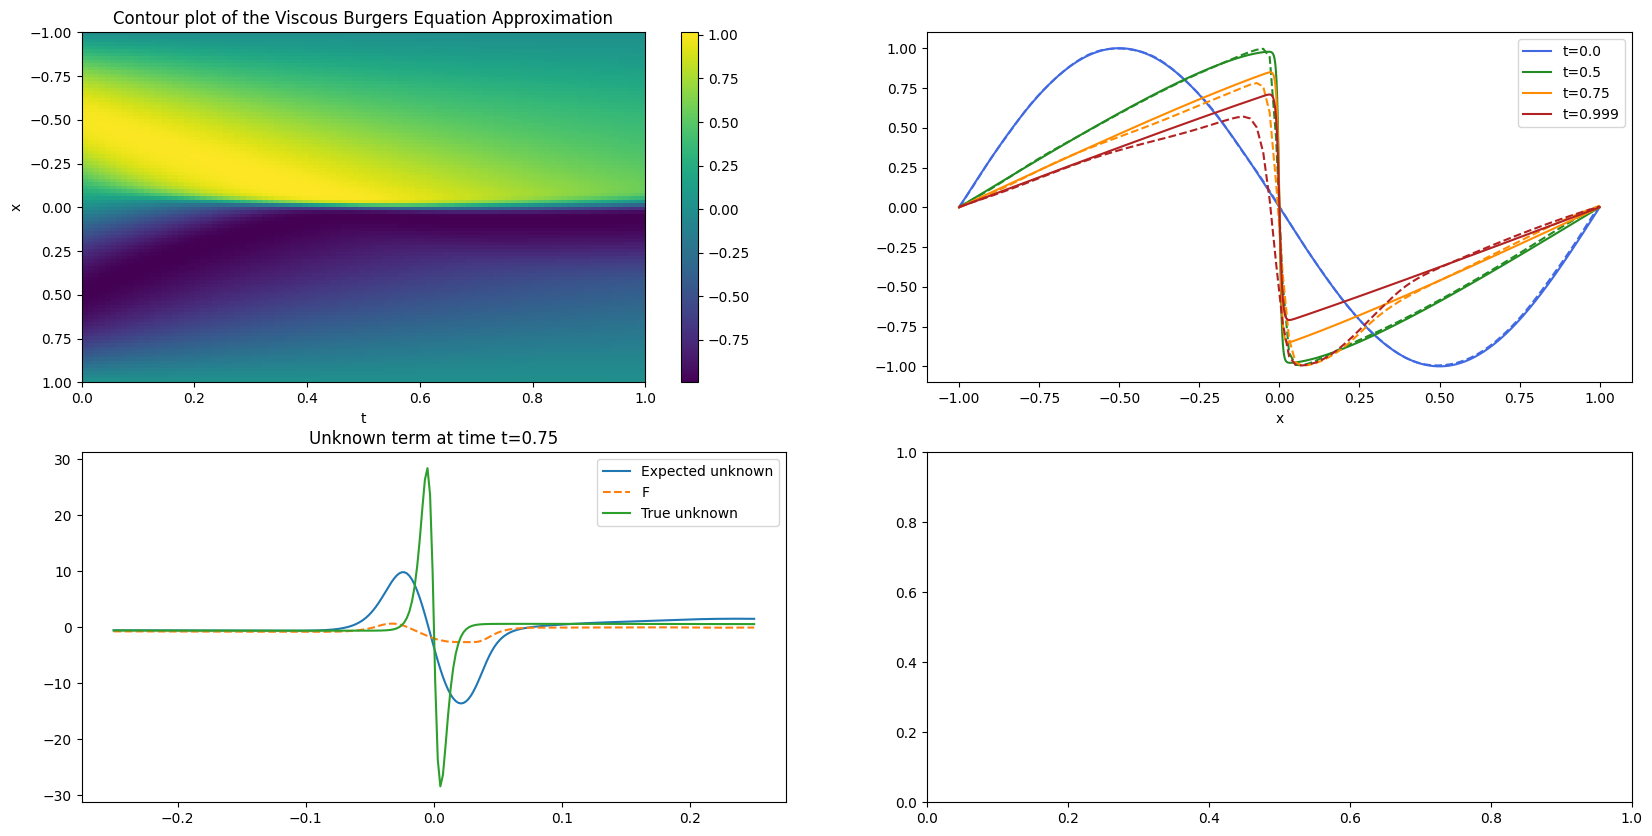

In [118]:
# lr = 2e-2
# optimizer = torch.optim.Adam([*u.parameters(), *f.parameters()], lr=lr)
lr_u = 2e-2
lr_f = 3e-2
optimizer_u = torch.optim.Adam(u.parameters(), lr=lr_u)
optimizer_f = torch.optim.Adam(f.parameters(), lr=lr_f)

phys_losses = []
losses = []

total_itr = 20001


for i in range(total_itr):
#     optimizer.zero_grad()
    optimizer_u.zero_grad()
    optimizer_f.zero_grad()
    
    tot_loss, loss1, loss2, loss3 = get_loss(boundary_points, boundary_targets, 
                                                         collocation_p, 
                                                         train_data, train_targets,
                                                        lambdas=(9e0, 2e1, 8e0))
    losses.append(tot_loss.item())
    
    tot_loss.backward()
#     optimizer.step()
    optimizer_u.step()
    optimizer_f.step()
    
    if i% 2000 == 0:
        print(f'Boundary L: {loss1.item()}, Phys L: {loss2.item()}, Data L: {loss3.item()}')
        plot_solution(usol, u, f)


In [119]:
# Save models
torch.save(u.state_dict(), './u_burgers.pt')
torch.save(f.state_dict(), './f_burgers.pt')

#### Use LBFGS optimizer

In [123]:
from torch.optim import LBFGS
lbfgs_optim = LBFGS([*u.parameters(), *f.parameters()], history_size=10, max_iter=4)

In [124]:
def closure():
    lbfgs_optim.zero_grad()
    tot_loss, _, _, _ = get_loss(boundary_points, boundary_targets, 
                                    collocation_p, 
                                    train_data, train_targets,
                                    lambdas=(1e0, 8e-1, 1e0))
    tot_loss.backward()
    return tot_loss

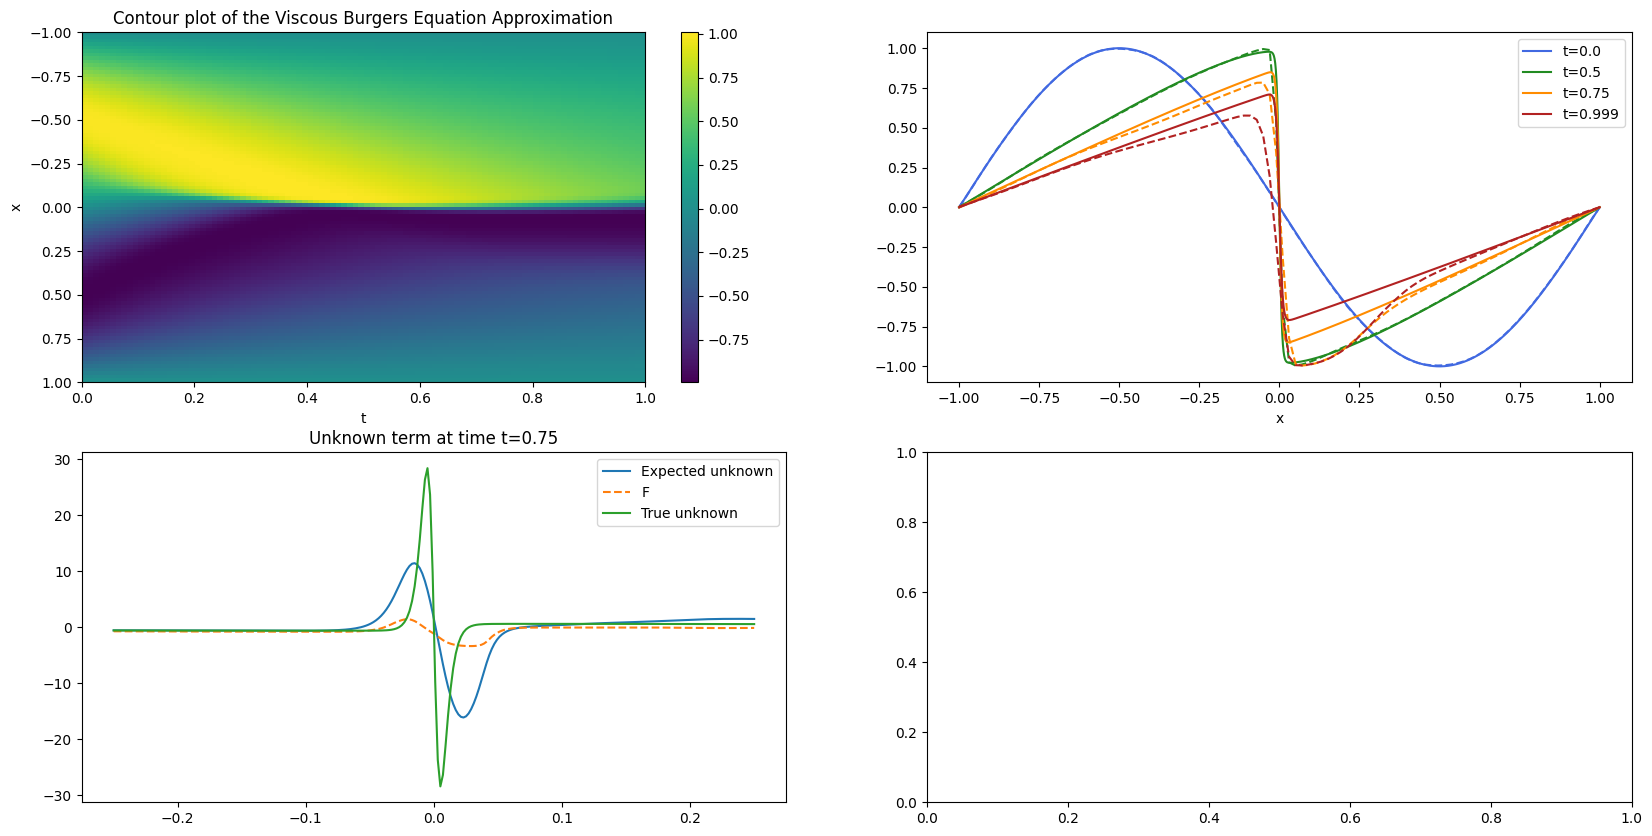

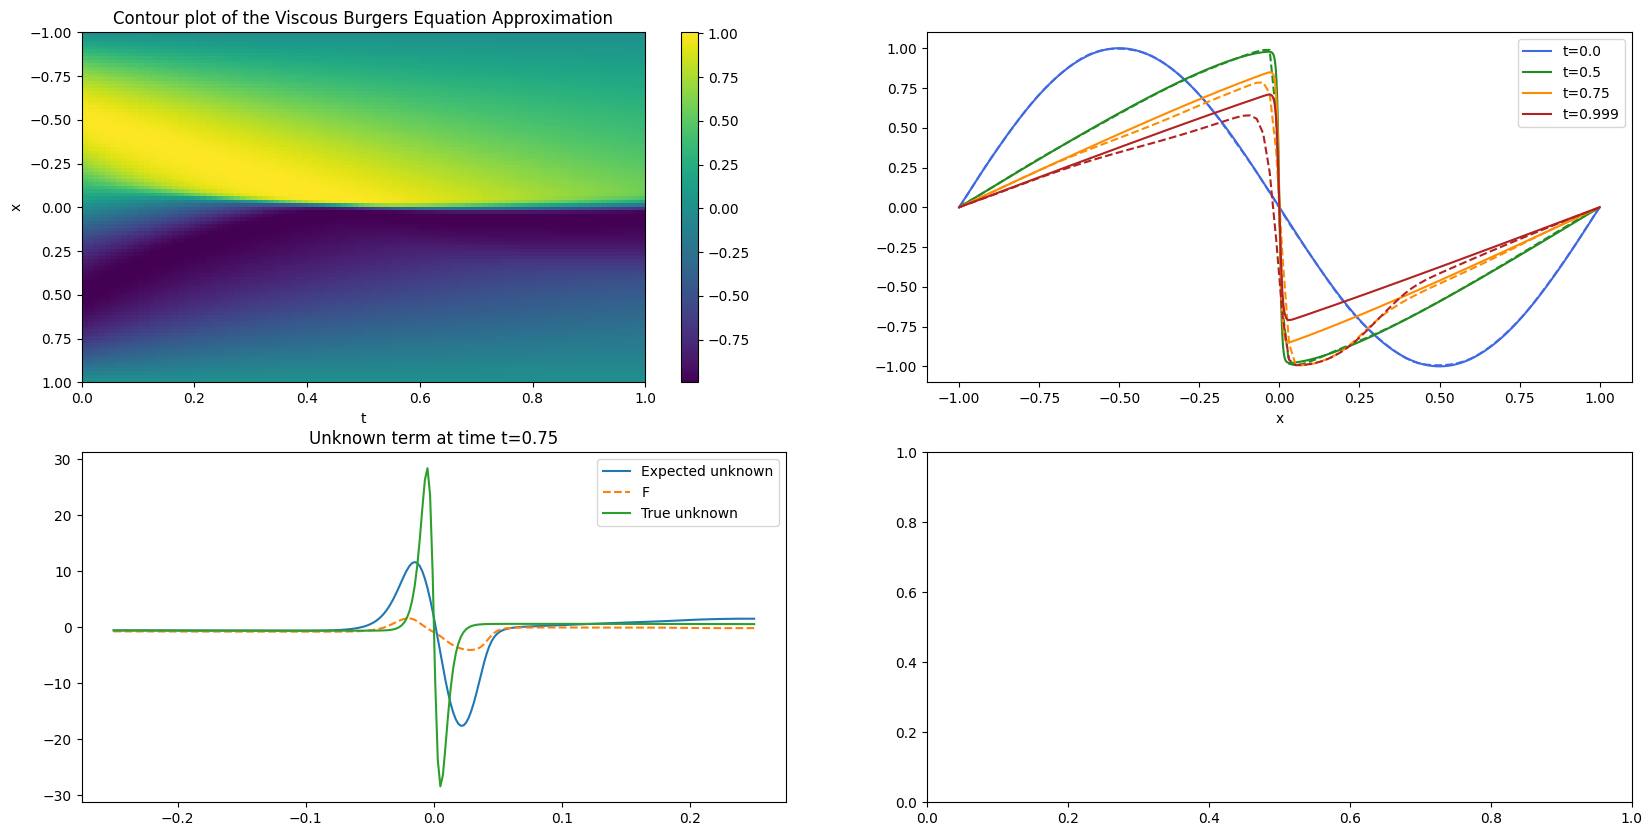

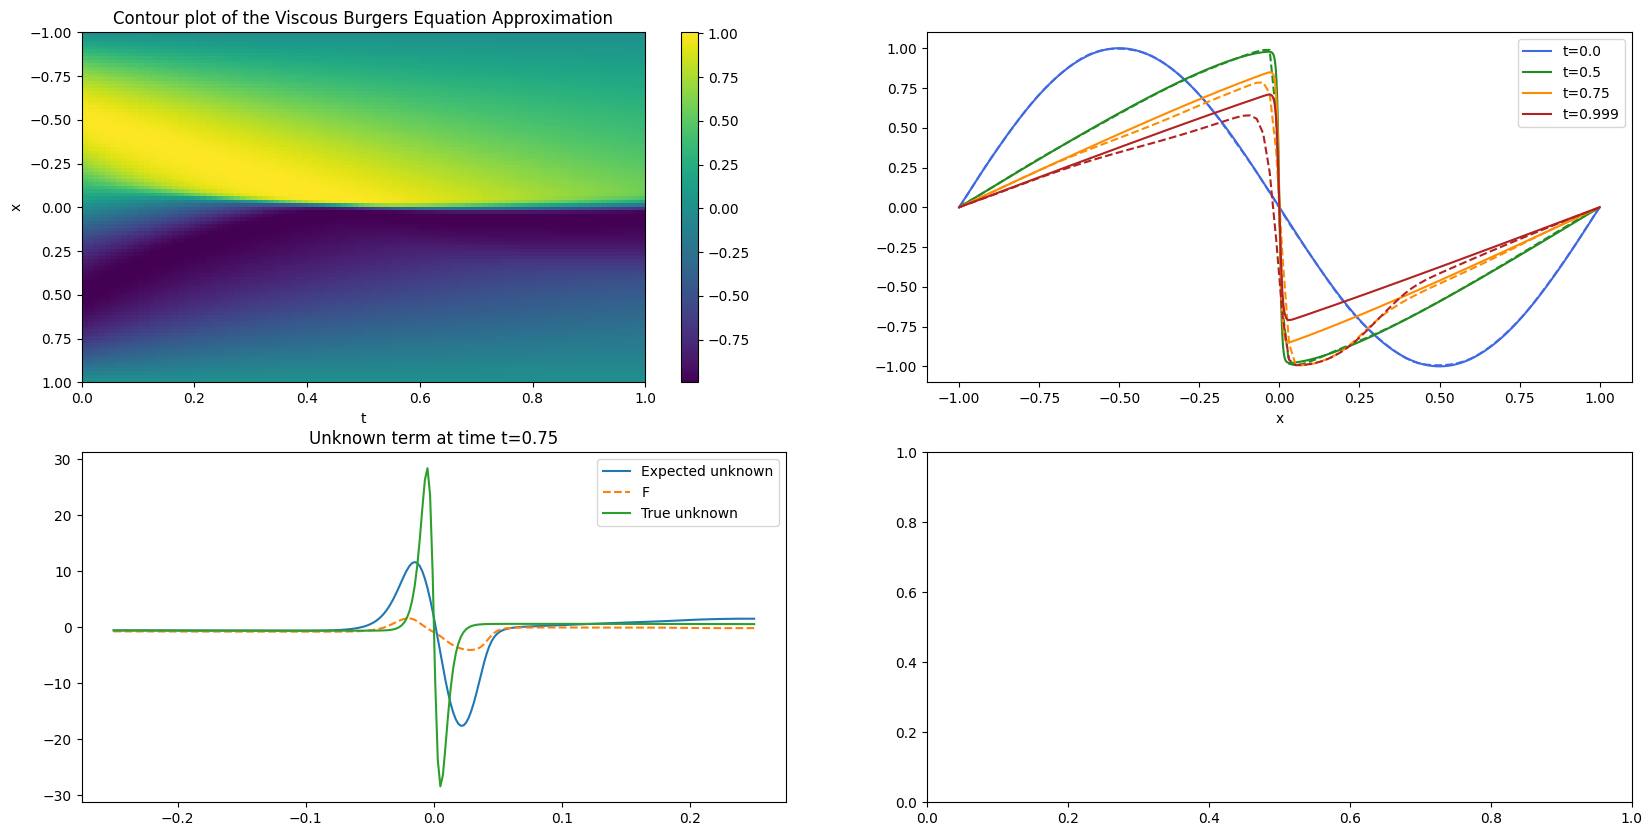

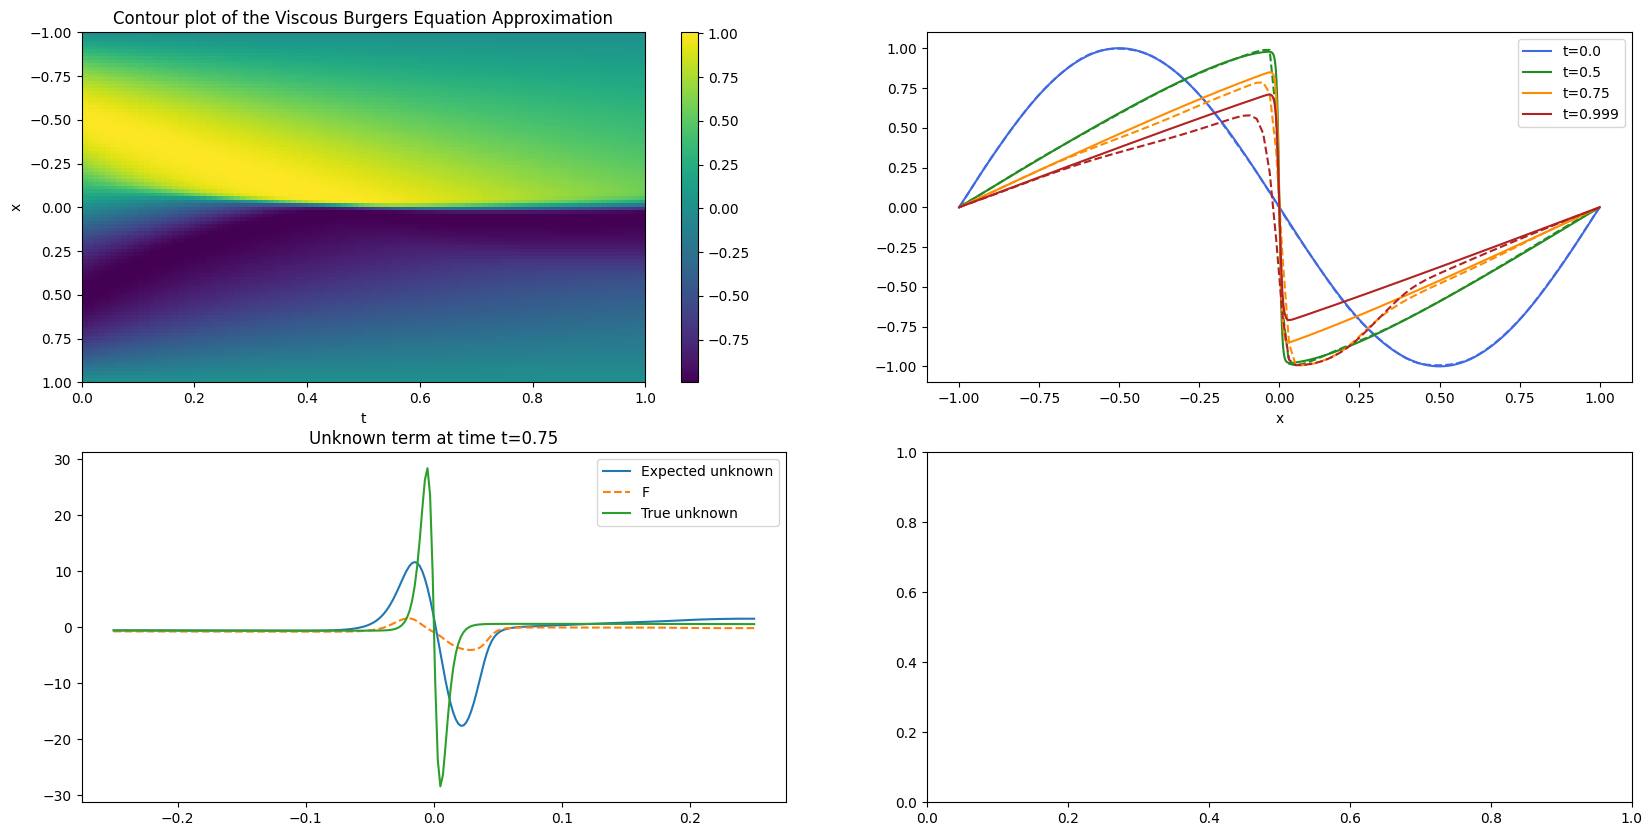

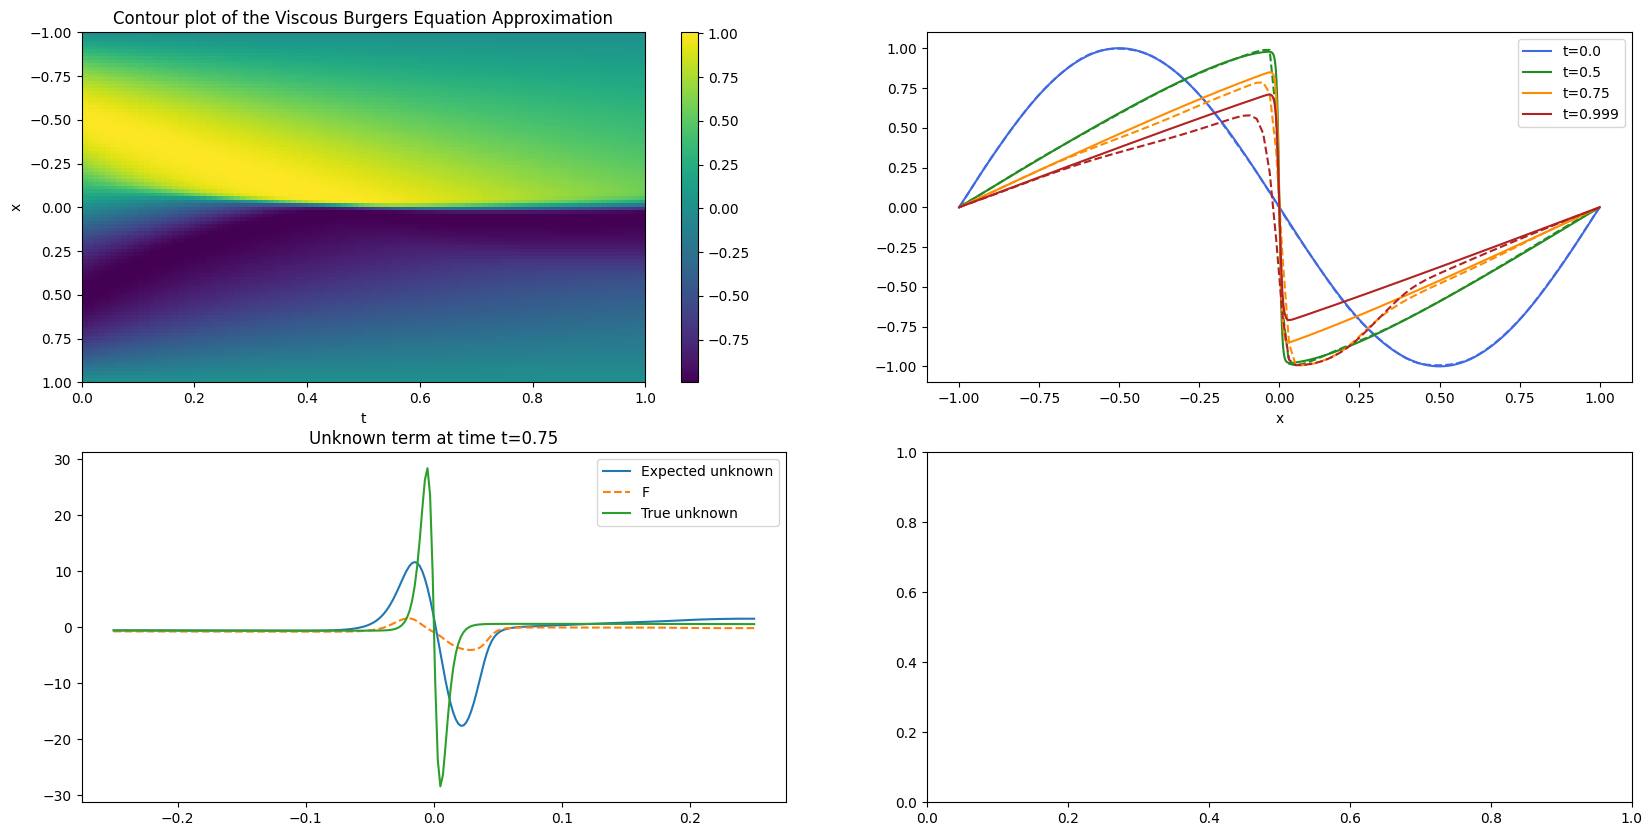

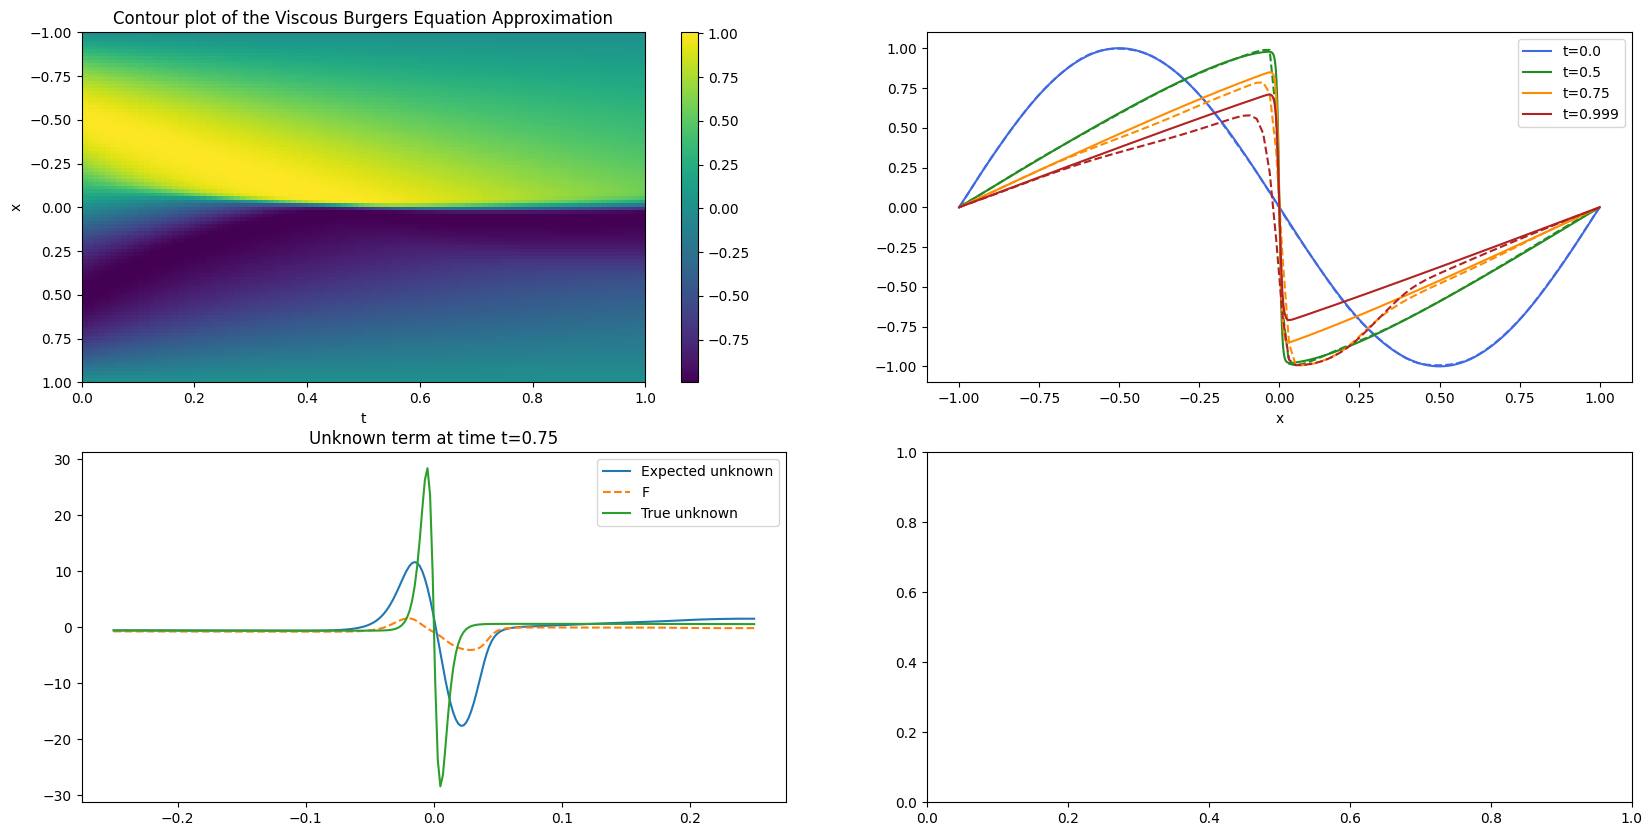

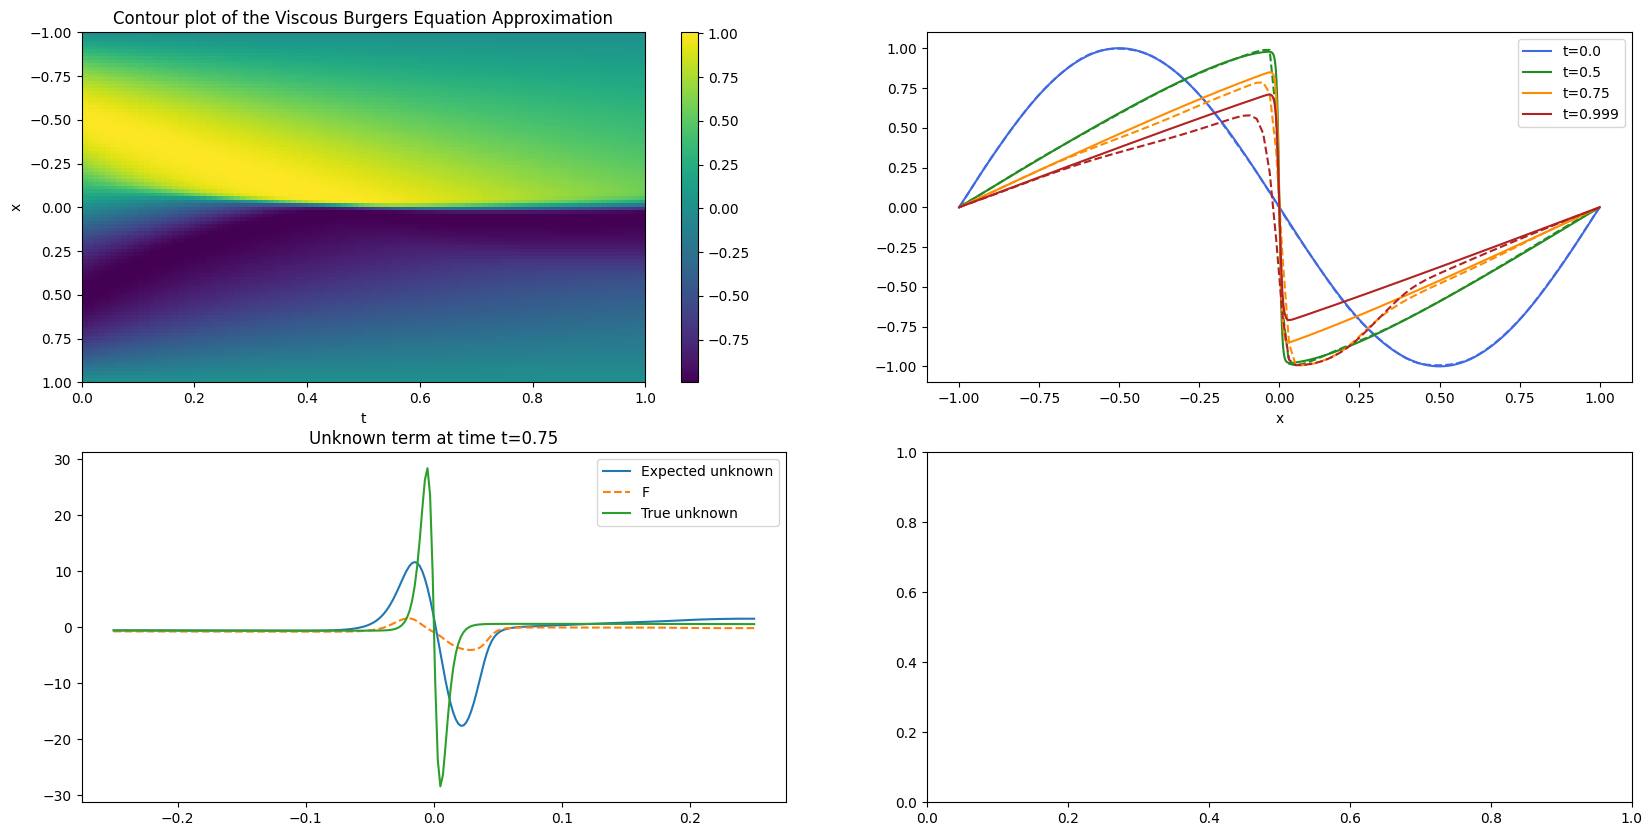

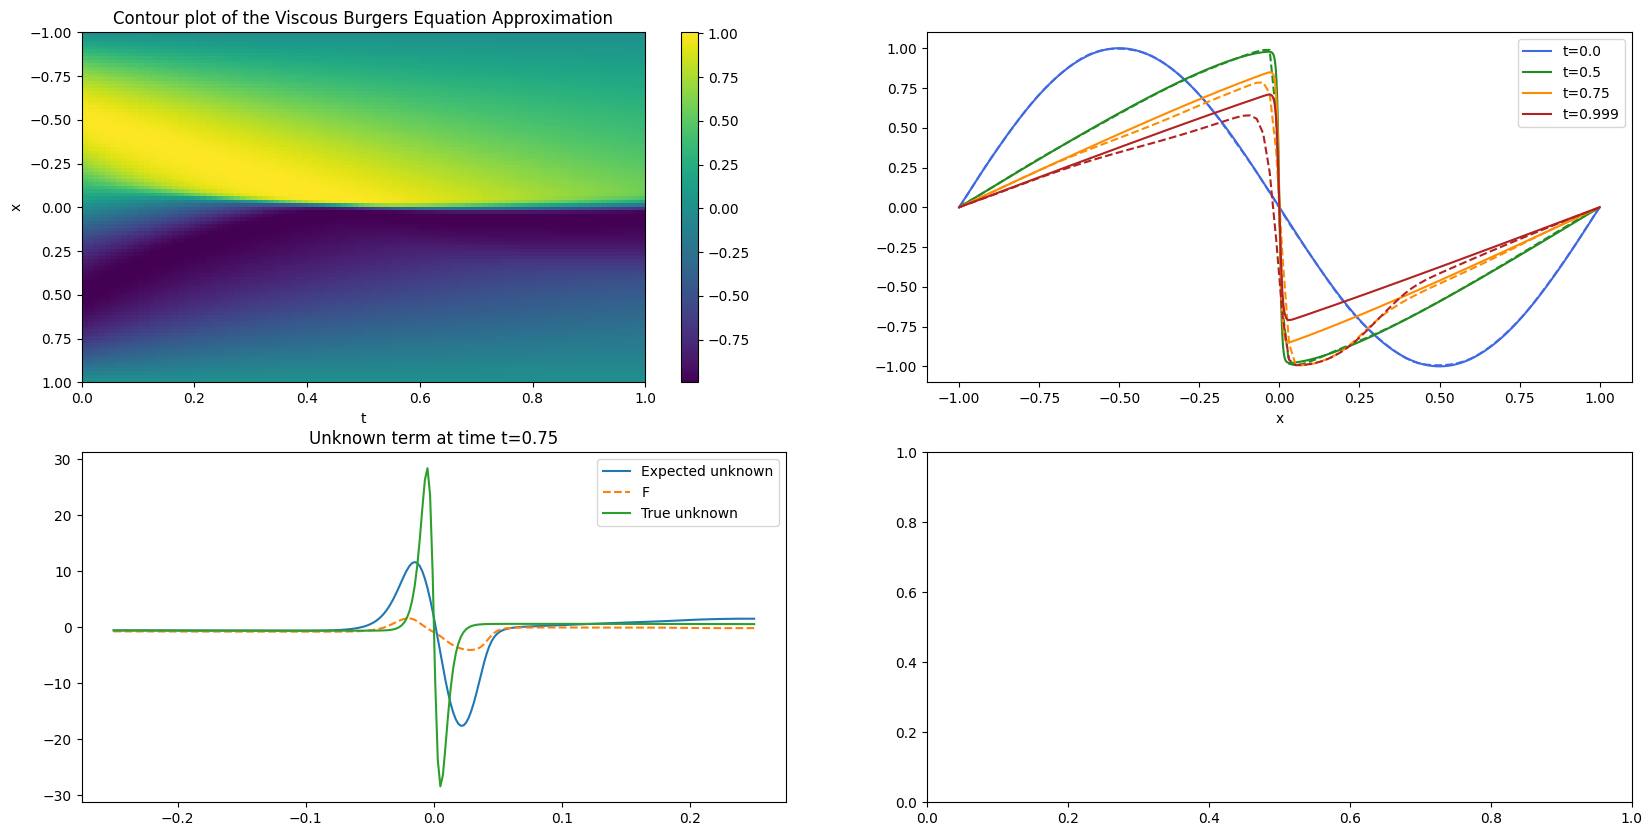

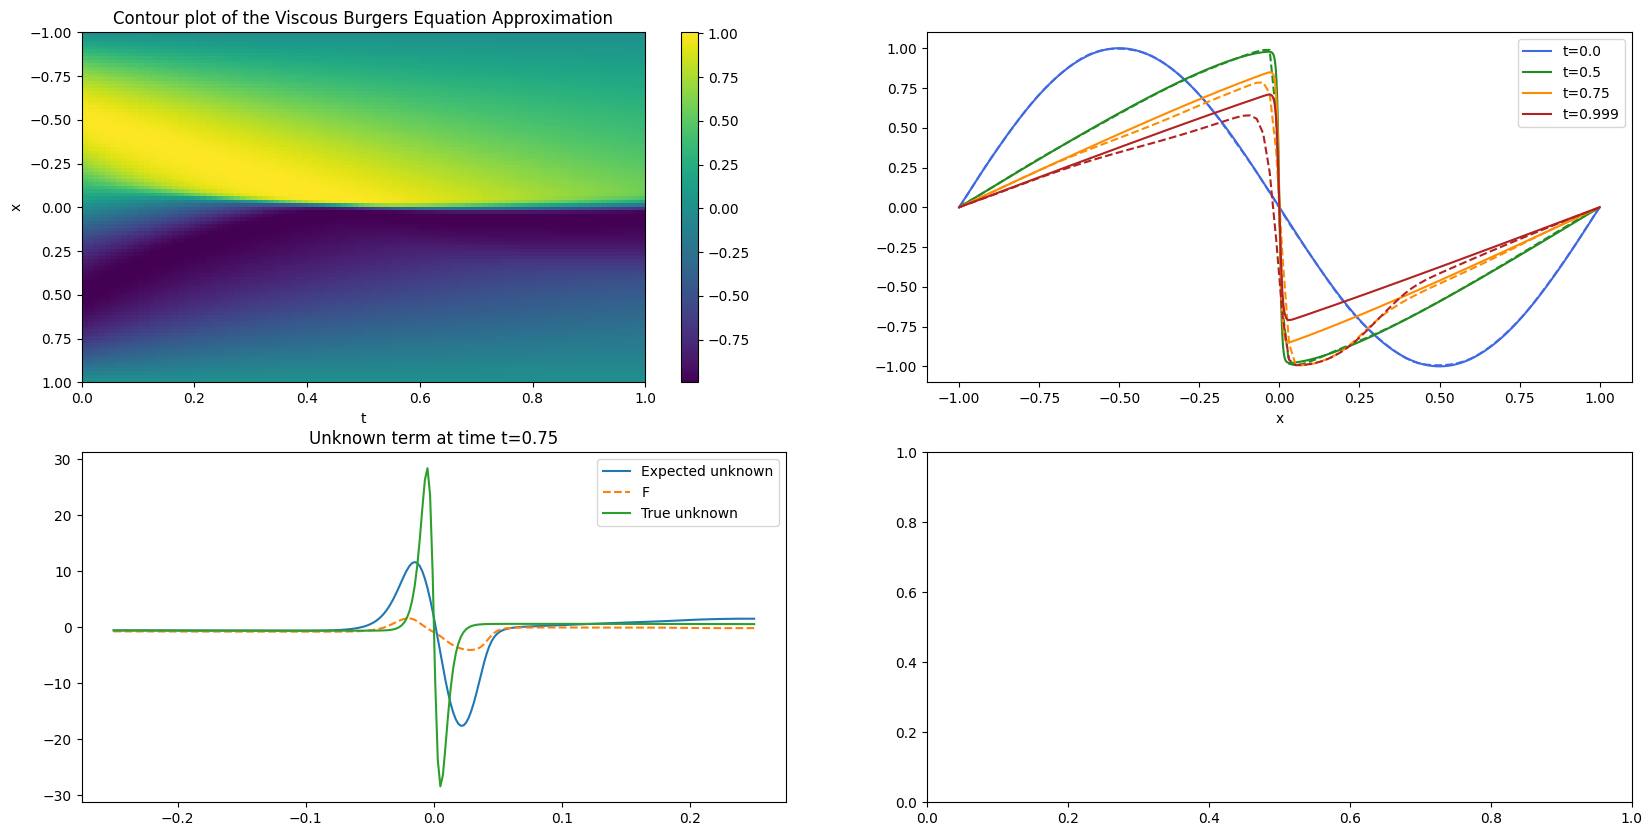

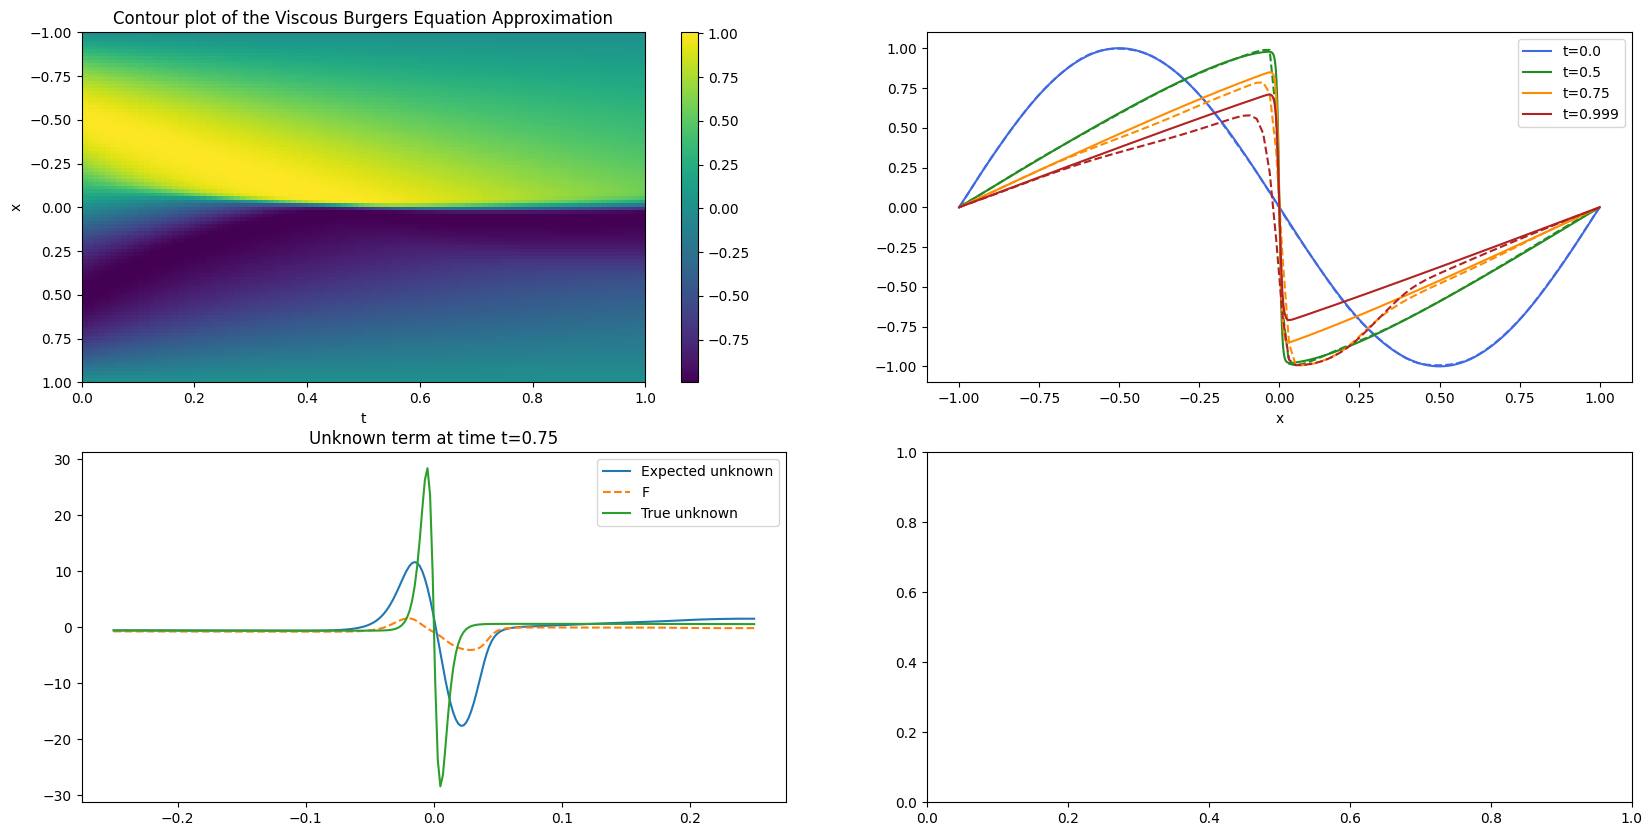

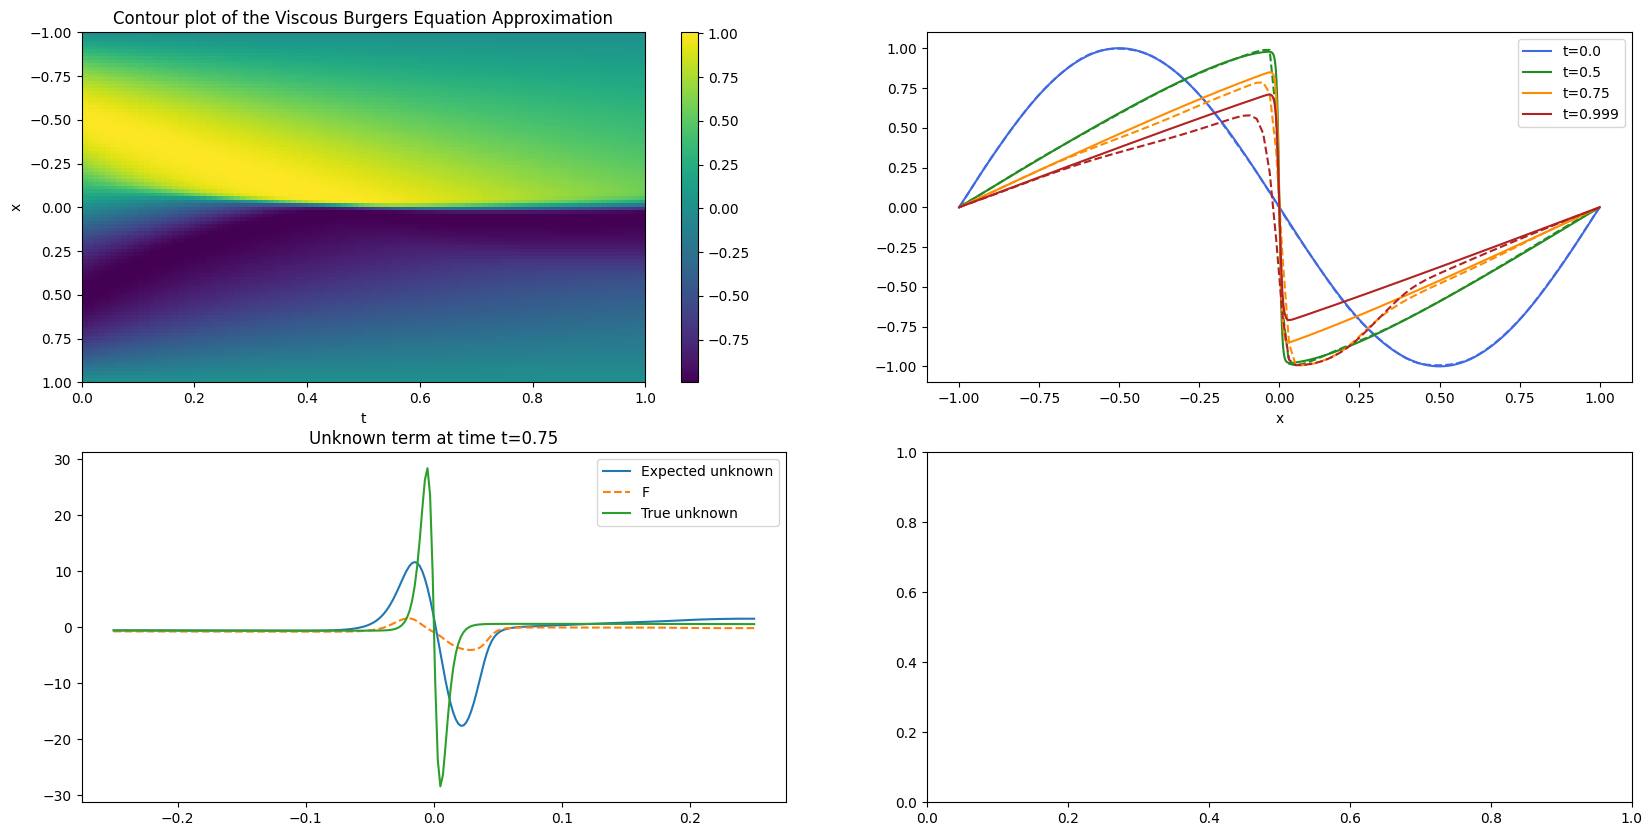

In [125]:
lbfgs_itr = 10001


for i in range(lbfgs_itr):
    lbfgs_optim.step(closure)
    
    if i%1000 == 0:
        plot_solution(usol, u, f)

In [126]:
# Save models
torch.save(u.state_dict(), './u_burgers_LBFGS.pt')
torch.save(f.state_dict(), './f_burgers_LBFGS.pt')